# Project Introduction: Retail Close Price Prediction



In the real estate industry, accurately predicting the **closing sale price** of a property is crucial for sellers, buyers, and agents. This project uses historical home sales data to build a model that can predict a home's closing price given various features of the property.
By analyzing past transactions, I aim to understand which factors drive sale prcies and to create a predictive tool to inform pricing strategy. The end goal is to help business stakeholders estimate final sla e prices more reliably, improving decision-making and negotiations.

### Data Loading and Prediction

To begin, I collected home sales data from multiple CSV files. These files contain detailed property information and the **ClosePrice**. I load each month's data and then combine them into one large dataset for analysis. In total, after combining, I have about **75,000 residential property records** with around 78 features each, covering sales from April through September. 

In [2]:
!pip install xgboost



import pandas as pd
import numpy as np
import math
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import (BernoulliNB, ComplementNB,
                                 GaussianNB, MultinomialNB)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             ConfusionMatrixDisplay)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings 
warnings.filterwarnings("ignore")

In [3]:
sold_4 = pd.read_csv("CRMLSSold202404_filled.csv")
sold_5 = pd.read_csv("CRMLSSold202405_filled.csv")
sold_6 = pd.read_csv("CRMLSSold202406_filled.csv")
sold_7 = pd.read_csv("CRMLSSold202407_filled.csv")
sold_8 = pd.read_csv("CRMLSSold202408.csv")
sold_9 = pd.read_csv("CRMLSSold202409.csv")
#78 features
sold_9.describe()

,OriginalListPrice,ListingKey,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,FireplacesTotal,AboveGradeFinishedArea,...,ElementarySchoolDistrict,BelowGradeFinishedArea,CoveredSpaces,Stories,LotSizeArea,MainLevelBedrooms,GarageSpaces,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
count,2.120700e+04,2.126700e+04,2.126700e+04,21255.000000,21259.000000,19887.000000,2.123300e+04,21267.000000,0.0,0.0,...,0.0,85.000000,0.0,16686.000000,1.920900e+04,11245.000000,18747.000000,14583.000000,1.918900e+04,0.0
mean,8.735104e+05,1.077351e+09,8.878023e+05,34.661718,-118.646205,1793.667723,8.521106e+05,38.100719,NaN,NaN,...,NaN,64.705882,NaN,1.369591,5.008817e+04,1.918808,1.773857,171.194245,4.914769e+05,NaN
std,1.413327e+06,1.264675e+07,5.435312e+06,1.675146,2.139629,1092.433583,1.329200e+06,58.631183,NaN,NaN,...,NaN,213.257101,NaN,0.482709,1.720012e+06,1.473979,4.797155,349.237033,1.887799e+07,NaN
min,1.290000e+00,4.216731e+08,0.000000e+00,0.000000,-124.144692,0.000000,1.000000e+00,-56.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,NaN
25%,1.199995e+05,1.076788e+09,1.000000e+05,33.751319,-118.838140,1176.000000,1.150000e+05,9.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,4.942000e+03,1.000000,1.000000,0.000000,5.117000e+03,NaN
50%,6.490000e+05,1.078860e+09,6.350000e+05,34.053712,-118.095467,1570.000000,6.384950e+05,21.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,6.970000e+03,2.000000,2.000000,0.000000,7.200000e+03,NaN
75%,1.089000e+06,1.079674e+09,1.070000e+06,34.543594,-117.359678,2117.000000,1.050000e+06,47.000000,NaN,NaN,...,NaN,0.000000,NaN,2.000000,1.113900e+04,3.000000,2.000000,285.000000,1.219700e+04,NaN
max,5.300000e+07,1.089078e+09,7.600000e+08,47.675461,0.000000,45322.000000,4.500000e+07,2414.000000,NaN,NaN,...,NaN,1200.000000,NaN,2.000000,1.414829e+08,47.000000,500.000000,12400.000000,1.498987e+09,NaN


The code above reads six CSV files (January through September sales). The `.describe()` summary confirms the data loaded correctly and gives an initial sense of the variables.
For example, we can see roughly **21,000 records** in the September file, and basic statistics like mean and max values. We immediately notice some **extreme values**: the average close price is around $887,800, byt the standard deviation is very high (several million dollaras), and the maximum ClosePrice is on the order of $.15 billion. This alerts me that the dataset contains a few extremely high sale prices that could skew my analysis. There are also features like latitude/longitude coordinates, property size (`LivingArea`), and days on market.Many columns show zero count, meaning they are entirely missing in that file. 

Next, I filter and combine the data. The dataset includes various property types, but my focus is on **single-family residential homes**. I remove other property types to ensure a consistent dataset. I also drop a few columns that are not relevant for prediciton or contain redundant information:
- **PropertyType/PropertySubType**: Used for filtering (I keep only `Residential` and `SingleFamilyResidence`).
- **BuyerAgent and LisitngAgent details**: These relate to agent commissions or assocations and do not directly influence home value from a buyer's perspective.
- **Latitude/Lonitude fill flags** (`latfilled`, `lonfiled`): These were intermediate columns that I no longer need once actual coordinates are in space.

After filtering, I concatenate the monthy DataFranmes into one master DataFrame for modeling.

In [4]:
sold_4 = sold_4[(sold_4["PropertyType"] == "Residential") & (sold_4["PropertySubType"] == "SingleFamilyResidence")].drop(["BuyerAgencyCompensationType", "BuyerAgencyCompensation", "latfilled", "lonfilled", "BuyerAgentAOR", "ListAgentAOR"], axis=1, errors='ignore')
sold_5 = sold_5[(sold_5["PropertyType"] == "Residential") & (sold_5["PropertySubType"] == "SingleFamilyResidence")].drop(["BuyerAgencyCompensationType", "BuyerAgencyCompensation", "latfilled", "lonfilled", "BuyerAgentAOR", "ListAgentAOR"], axis=1, errors='ignore')
sold_6 = sold_6[(sold_6["PropertyType"] == "Residential") & (sold_6["PropertySubType"] == "SingleFamilyResidence")].drop(["BuyerAgencyCompensationType", "BuyerAgencyCompensation", "latfilled", "lonfilled", "BuyerAgentAOR", "ListAgentAOR"], axis=1, errors='ignore')
sold_7 = sold_7[(sold_7["PropertyType"] == "Residential") & (sold_7["PropertySubType"] == "SingleFamilyResidence")].drop(["BuyerAgencyCompensationType", "BuyerAgencyCompensation", "latfilled", "lonfilled", "BuyerAgentAOR", "ListAgentAOR"], axis=1, errors='ignore')
sold_8 = sold_8[(sold_8["PropertyType"] == "Residential") & (sold_8["PropertySubType"] == "SingleFamilyResidence")].drop(["BuyerAgencyCompensationType", "BuyerAgencyCompensation", "latfilled", "lonfilled", "BuyerAgentAOR", "ListAgentAOR"], axis=1, errors='ignore')
sold_9 = sold_9[(sold_9["PropertyType"] == "Residential") & (sold_9["PropertySubType"] == "SingleFamilyResidence")].drop(["BuyerAgencyCompensationType", "BuyerAgencyCompensation", "latfilled", "lonfilled", "BuyerAgentAOR", "ListAgentAOR"], axis=1, errors='ignore')

sold_9.head()

,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,CloseDate,ClosePrice,...,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
0,NaN,False,NaN,NaN,False,1130000.0,538338723,espi.bagwell@kw.com,2024-09-12,1090000.0,...,NaN,14390.0,3.0,False,0.0,Monrovia Unified,91016,0.0,14390.0,NaN
7,Tile,True,NaN,NaN,True,1995000.0,1089077716,john@johnbomgardner.com,2024-09-30,1995000.0,...,NaN,18295.0,NaN,False,3.0,NaN,92270,850.0,18295.0,NaN
8,Wood,True,NaN,NaN,True,2340000.0,1089076111,andrea@ballesterosgroup.com,2024-09-30,2340000.0,...,NaN,11900.0,1.0,False,2.0,Capistrano Unified,92677,240.0,11900.0,NaN
9,NaN,True,NaN,NaN,True,984000.0,1089075731,Cindy@kellemsrealtyproject.com,2024-09-30,984000.0,...,NaN,6500.0,NaN,NaN,2.0,San Diego Unified,92119,0.0,6500.0,NaN
10,"Carpet,Stone,Tile",True,NaN,NaN,False,1250000.0,1089075621,lynnw@loislauer.com,2024-09-30,1225000.0,...,NaN,5338.0,3.0,False,2.5,Redlands Unified,92373,425.0,5338.0,NaN


In [5]:
sold_4to9 = pd.concat([sold_4, sold_5, sold_6, sold_7, sold_8, sold_9], ignore_index = True)

sold_4to9.describe()

,OriginalListPrice,ListingKey,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,FireplacesTotal,AboveGradeFinishedArea,...,ElementarySchoolDistrict,BelowGradeFinishedArea,CoveredSpaces,Stories,LotSizeArea,MainLevelBedrooms,GarageSpaces,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
count,7.572200e+04,7.584100e+04,7.584000e+04,75791.000000,75791.000000,75804.000000,7.584100e+04,75841.000000,0.0,0.0,...,0.0,404.000000,0.0,64100.000000,7.460600e+04,43859.000000,73264.000000,51581.000000,7.460100e+04,0.0
mean,1.324539e+06,1.069929e+09,1.293565e+06,34.891159,-118.806463,2027.878819,1.270190e+06,28.536095,NaN,NaN,...,NaN,87.540124,NaN,1.354243,2.086280e+04,2.345357,2.035775,99.610392,2.134110e+05,NaN
std,5.671546e+06,9.493609e+06,2.077014e+06,1.769022,2.911921,1120.557082,1.418558e+06,61.441387,NaN,NaN,...,NaN,278.733930,NaN,0.478287,6.580694e+05,16.055197,5.643912,302.105268,1.147468e+07,NaN
min,1.200000e+00,4.927085e+08,3.450000e+02,0.000000,-177.646696,0.000000,5.250000e+02,-84.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,NaN
25%,6.390000e+05,1.063484e+09,6.350885e+05,33.776408,-120.674379,1371.000000,6.300000e+05,7.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,5.502000e+03,1.000000,2.000000,0.000000,5.663000e+03,NaN
50%,8.999990e+05,1.073217e+09,9.200000e+05,34.115720,-118.097527,1798.000000,8.995000e+05,13.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,7.119000e+03,3.000000,2.000000,0.000000,7.233000e+03,NaN
75%,1.488000e+06,1.076528e+09,1.500000e+06,36.725029,-117.290196,2416.000000,1.450000e+06,34.000000,NaN,NaN,...,NaN,0.000000,NaN,2.000000,9.933000e+03,3.000000,2.000000,126.000000,1.021500e+04,NaN
max,1.325000e+09,1.089078e+09,3.750000e+08,56.130366,120.634389,123764.000000,7.800000e+07,12430.000000,NaN,NaN,...,NaN,2325.000000,NaN,2.000000,1.350360e+08,3333.000000,600.000000,17875.000000,1.633500e+09,NaN


In [6]:
len(sold_4to9)

75841

This shows that the `sold_4to9` dataframe, which contains the data from April to September has over **75,000** rows.

Before proceeding to the data cleaning, I want to know about how many missing values each columns have. 

In [7]:
sold_4to9.isnull().sum().sort_values(ascending = False).head(15)

MiddleOrJuniorSchoolDistrict    75841
CoveredSpaces                   75841
FireplacesTotal                 75841
AboveGradeFinishedArea          75841
TaxAnnualAmount                 75841
TaxYear                         75841
BusinessType                    75841
ElementarySchoolDistrict        75841
WaterfrontYN                    75816
BelowGradeFinishedArea          75437
BasementYN                      73988
BuilderName                     72396
BuildingAreaTotal               71429
LotSizeDimensions               71408
CoBuyerAgentFirstName           69200
dtype: int64

In [8]:
print("There are", (sold_4to9.isnull().sum() > 0).sum(), "columns with missing values in the dataset.")
print("There are", (sold_4to9.isnull().sum() > 70000).sum(), "columns with more than 70,000 missing values in the dataset.")

There are 59 columns with missing values in the dataset.
There are 14 columns with more than 70,000 missing values in the dataset.


In [9]:
over_70k_missing = sold_4to9.columns[sold_4to9.isnull().sum() > 70000]
over_70k_missing

Index(['WaterfrontYN', 'BasementYN', 'FireplacesTotal',
       'AboveGradeFinishedArea', 'TaxAnnualAmount', 'BuilderName', 'TaxYear',
       'BuildingAreaTotal', 'ElementarySchoolDistrict',
       'BelowGradeFinishedArea', 'BusinessType', 'CoveredSpaces',
       'LotSizeDimensions', 'MiddleOrJuniorSchoolDistrict'],
      dtype='object')

## Data Cleaning

With the full dataset prepared, the next step is to clean and preprocess the data for analysis: 


#### Dropping Irrelevant or Redundant Columns

To improve model performace and avoid noise, I removed several columns that were either: 
- **Redundant or duplicative**
- **Unavailable at prediciton time**
- **Non-numeric or high-cardinality text fields**
- **Not directly informative about property value**

Removing these columns helps simplify the dataset, prevent data leakage, and focus the model on core, meaningful property features like size, layout, amenities, and locaiton. After dropping them, we retain a streamlined and effective set of variables for price prediciton. 

In [10]:
drop_columns = ['ListPrice', 'OriginalListPrice', 'CoListOfficeName',
               'ListingKey', 'ListAgentEmail', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName',
               'CoListAgentFirstName', 'CoListAgentLastName', 'BuyerAgentMlsId', 'BuyerAgentFirstName',
               'BuyerAgentLastName', 'ListingKeyNumeric', 'MLSAreaMajor', 'MlsStatus', 'BuyerOfficeAOR',
               'ListingID', 'ContractStatusChangeDate', 'CoBuyerAgentFirstName', 'PurchaseContractDate',
               'ListingContractDate', 'BelowGradeFinishedArea', 'Business Type', 'MainLevelBedrooms',
               'LotSizeAcres', 'LotSizeDimensions', 'LotSizeArea', 'Close Date', 'AssociationFeeFrequency',
               'TaxAnnualAmount', 'BuilderName', 'SubdivisionName', 'TaxYear', 'AssociationFee', "ListAgentFirstName",
               "ListAgentLastName"]
existing_columns = [col for col in drop_columns if col in sold_9.columns]

# Drop them
sold_df = sold_4to9.drop(columns=existing_columns)

sold_df.shape

(75841, 42)

#### Drop Columns with No Data

Some columns are completely empty (or all null) across the dataset. I automatically remove any such columns to simplify the dataset, since they carry no information. For instance, if a column like `MiddleOrJuniorSchoolDistrict` has no entires at all, it's dropped.


In [11]:
def drop_no_value_columns(df):
    null_columns = df.columns[df.isnull().sum() == len(df)]
    df = df.drop(columns = null_columns)
    return df

In [12]:
sold_df_2 = drop_no_value_columns(sold_df)

sold_df_2.head()

,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,UnparsedAddress,...,MiddleOrJuniorSchool,FireplaceYN,Stories,HighSchool,Levels,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,LotSizeSquareFeet
0,NaN,True,NaN,NaN,False,2024-04-02,250000.0,36.783028,-119.768450,3533 Virginia Lane N,...,Talbert,True,2.0,Beaumont,Two,False,2.0,Fresno Unified,93726,8100.0
1,NaN,True,NaN,NaN,False,2024-04-30,413700.0,33.605045,-116.473489,68252 Materhorn,...,NaN,True,1.0,NaN,One,False,3.0,Palm Springs Unified,92561,43560.0
2,NaN,True,NaN,NaN,False,2024-04-03,725000.0,32.554950,-117.049710,2378 Smythe Avenue,...,NaN,False,1.0,NaN,One,NaN,2.0,Sweetwater Union,92173,10557.0
3,NaN,False,NaN,NaN,False,2024-04-12,600000.0,32.742623,-116.988226,3457 Kenora Dr,...,NaN,False,1.0,NaN,One,False,2.0,NaN,91977,8130.0
4,"Tile,Wood",NaN,NaN,NaN,False,2024-04-10,1810000.0,37.841644,-122.128606,846 Crossbrook Ct,...,NaN,True,1.0,NaN,One,False,2.0,NaN,94556,15600.0


The function `drop_no_value_columns` finds any column where the number of nulls equals the number of rows (meaning the column is entirely empty) and drops it. After this, `sold_df.head()` shows the first few rows of the remaining the data. This confirms that purely empty fields (like certain school district fields in some monthly files) are removed. We still retain dozens of useful featurs.

#### Conver Yes/NO Falgs

Many fetures are sorted as boolean Yes/No or have Y/N suffix. These are categorical indicators that need to be converted to numeric form for modeling. I also see that some of these entries could be missing (nan), meaning "unknown". Rather than drop these records, we treat "Missing" as a separate category because an unknown feature stae could still have meaning. 

I perform **one-hot encoding** on each `YN` column, creating separate binary columns for True, False, and Missing. This ensures the model can use these features. For example, a column `PoolPrivateYN` will be transformed into three new columns: `PoolPrivateYN_True`, `PoolPrivateYN_False`, and `PoolPrivateYN_Missing` (with 1s and 0s indicating the presence of each condition). 
This way, a house with `PoolPrivateYN = True` will have a 1 in `PoolPrivateYN_False`, and houses where this info wasn't provided will have 1 in `PoolPrivateYN_Missing`.

In [13]:
YN_columns = [col for col in sold_df_2.columns if col.endswith('YN')]

YN_columns

['ViewYN',
 'WaterfrontYN',
 'BasementYN',
 'PoolPrivateYN',
 'AttachedGarageYN',
 'FireplaceYN',
 'NewConstructionYN']

In [14]:
def process_categorical_columns(df, column_name, expected_values = None):

    if column_name not in df.columns:
        print(f"Warning: Column '{column_name}' not found in DataFrame.")
    df[column_name] = df[column_name].fillna("Missing").astype(str)
    df[column_name] = df[column_name].astype(str)
    df = pd.get_dummies(df, columns = [column_name], drop_first = False)

    if expected_values:
        for val in expected_values: 
            dummy_col = f"{column_name}_{val}"
            if dummy_col not in df.columns:
                df[dummy_col] = 0
            else: 
                df[dummy_col] = (df[dummy_col] == True).astype(int)
    return df

In [15]:
for col in YN_columns:
    sold_df_2 = process_categorical_columns(sold_df_2, col, expected_values = ['True', 'False', 'Missing'])

sold_df_2.head()

,Flooring,CloseDate,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,ListAgentFullName,CountyOrParish,...,PoolPrivateYN_True,AttachedGarageYN_False,AttachedGarageYN_Missing,AttachedGarageYN_True,FireplaceYN_False,FireplaceYN_Missing,FireplaceYN_True,NewConstructionYN_False,NewConstructionYN_Missing,NewConstructionYN_True
0,NaN,2024-04-02,250000.0,36.783028,-119.768450,3533 Virginia Lane N,Residential,1723.0,Michael Garabedian,Fresno,...,0,0,0,1,0,0,1,1,0,0
1,NaN,2024-04-30,413700.0,33.605045,-116.473489,68252 Materhorn,Residential,2285.0,Robyn Garrison,Riverside,...,0,0,0,1,0,0,1,1,0,0
2,NaN,2024-04-03,725000.0,32.554950,-117.049710,2378 Smythe Avenue,Residential,1716.0,Mary Villalobos,San Diego,...,0,0,0,1,1,0,0,0,1,0
3,NaN,2024-04-12,600000.0,32.742623,-116.988226,3457 Kenora Dr,Residential,1600.0,Jeffrey Whittington,San Diego,...,0,0,0,1,1,0,0,1,0,0
4,"Tile,Wood",2024-04-10,1810000.0,37.841644,-122.128606,846 Crossbrook Ct,Residential,2001.0,Leila Santos,Contra Costa,...,0,0,0,1,0,0,1,1,0,0


After this tranformation, our dataset now has additional columns such as `PoolPrivateYN_True`, `PoolPrivateYN_False`, `PoolPrivateYN_Missing`, and similarly for other YN features. Checking the `head` of `sold_df_2`, we can see these new indicator columns. 
By converting these categorical flags into numerical form, I preserve information like "this house has a pool" or "unknown if it has a pool" in a way the model can use. 

In [16]:
sold_df_2.isnull().sum()

Flooring                     26631
CloseDate                        0
ClosePrice                       1
Latitude                        50
Longitude                       50
UnparsedAddress                 59
PropertyType                     0
LivingArea                      37
ListAgentFullName                6
CountyOrParish                   0
ElementarySchool             64532
ParkingTotal                     0
PropertySubType                  0
YearBuilt                       56
StreetNumberNumeric             76
ListingId                        0
BathroomsTotalInteger           17
City                            79
BuildingAreaTotal            71429
BedroomsTotal                    0
StateOrProvince                  0
MiddleOrJuniorSchool         64420
Stories                      11741
HighSchool                   61226
Levels                        9387
GarageSpaces                  2577
HighSchoolDistrict           18967
PostalCode                       0
LotSizeSquareFeet   

In [17]:
print("There are", (sold_df_2.isnull().sum() > 0).sum(), "columns have at least one missing value in the dataset.")

There are 20 columns have at least one missing value in the dataset.


The ouput of the above shows how many features still have nulls. 

For features that are crucial and have only a few missing entries, I will consider imputation or dropping those specific records. For features that are mostly missing or not essential, I may frop the feature. For instance, fields related to specifc school names are often missing or have too many unique values. These likely won't generalize well in a model and can be removed to simplify our data.


#### Drop High-Cardinality or Irrelevant Columns

I remove the specific school name columns since they are largely unique identifers and not directlu useful for predicting price. By removing `ElementarySchool`, `MiddleOrJuniorSchool`, and `HighSchool` columns, I reduce noise. 

In [18]:
school_drop_col = ['ElementarySchool', 'MiddleOrJuniorSchool', 'HighSchool']

sold_df_3 = sold_df_2.drop(columns = school_drop_col, errors = 'ignore')

sold_df_3.head()

,Flooring,CloseDate,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,ListAgentFullName,CountyOrParish,...,PoolPrivateYN_True,AttachedGarageYN_False,AttachedGarageYN_Missing,AttachedGarageYN_True,FireplaceYN_False,FireplaceYN_Missing,FireplaceYN_True,NewConstructionYN_False,NewConstructionYN_Missing,NewConstructionYN_True
0,NaN,2024-04-02,250000.0,36.783028,-119.768450,3533 Virginia Lane N,Residential,1723.0,Michael Garabedian,Fresno,...,0,0,0,1,0,0,1,1,0,0
1,NaN,2024-04-30,413700.0,33.605045,-116.473489,68252 Materhorn,Residential,2285.0,Robyn Garrison,Riverside,...,0,0,0,1,0,0,1,1,0,0
2,NaN,2024-04-03,725000.0,32.554950,-117.049710,2378 Smythe Avenue,Residential,1716.0,Mary Villalobos,San Diego,...,0,0,0,1,1,0,0,0,1,0
3,NaN,2024-04-12,600000.0,32.742623,-116.988226,3457 Kenora Dr,Residential,1600.0,Jeffrey Whittington,San Diego,...,0,0,0,1,1,0,0,1,0,0
4,"Tile,Wood",2024-04-10,1810000.0,37.841644,-122.128606,846 Crossbrook Ct,Residential,2001.0,Leila Santos,Contra Costa,...,0,0,0,1,0,0,1,1,0,0


I doubt that `BuildingAreaTotal` and `LivingArea` have same values or at least simmilar values, so I will confirm my assumption. 

In [19]:
filtered_df = sold_df_3[['BuildingAreaTotal', 'LivingArea']].dropna(subset = ['BuildingAreaTotal'])

filtered_df

,BuildingAreaTotal,LivingArea
9,4185.0,4185.0
10,1284.0,1284.0
28,832.0,832.0
35,2288.0,2288.0
56,2880.0,2880.0
...,...,...
75815,4626.0,4626.0
75826,1522.0,1522.0
75829,2051.0,2051.0
75837,1708.0,1708.0


In [20]:
unmatched_df = filtered_df[filtered_df['BuildingAreaTotal'] != filtered_df['LivingArea']]
len(unmatched_df)

0

As you can see,  the `BuildingAreaTotal` and `LivingArea` has exactly same values which mean duplicated.
Therefore, I will drop the `BuildingAreaTotal` since it has more missing values compared to the `LivingArea`.

In [21]:
sold_df_4 = sold_df_3.drop(columns = 'BuildingAreaTotal')
sold_df_4.isnull().sum()

Flooring                     26631
CloseDate                        0
ClosePrice                       1
Latitude                        50
Longitude                       50
UnparsedAddress                 59
PropertyType                     0
LivingArea                      37
ListAgentFullName                6
CountyOrParish                   0
ParkingTotal                     0
PropertySubType                  0
YearBuilt                       56
StreetNumberNumeric             76
ListingId                        0
BathroomsTotalInteger           17
City                            79
BedroomsTotal                    0
StateOrProvince                  0
Stories                      11741
Levels                        9387
GarageSpaces                  2577
HighSchoolDistrict           18967
PostalCode                       0
LotSizeSquareFeet             1240
ViewYN_False                     0
ViewYN_Missing                   0
ViewYN_True                      0
WaterfrontYN_Missing

In addition, it's impossible to identify the `UnparsedAddress` without using information, and there are not that much missing values in the column, I decided to just drop the rows with missing value of `UnparsedAddress`. 

In [22]:
sold_df_4 = sold_df_4.dropna(subset=['UnparsedAddress']).reset_index(drop=True)

I also noticed some properties were missing latitude/longitude values. Instaed of dropping those properties, I attempted to fill in coordinates based on address clues. 
I did this for a handful of properties by identifying patterns in `UnparsedAddress` and assigning approximate latitude/longitude for those. This level of manual data enrichment shows my commitment to preserving data, by filling in these missing geo-coordinates, I can include those properties in my analysis rather than exclude them.

After filling those, **all properties now have valid coordinates**. 

In [23]:
sold_df_4[sold_df_4['Longitude'].isna()][['Longitude', 'Latitude', 'UnparsedAddress']]

,Longitude,Latitude,UnparsedAddress
1775,NaN,NaN,0 SE Corner Santa Fe & 3rd
17221,NaN,NaN,Torres & 1st Street
24826,NaN,NaN,0 NW Corner of Carmelo & 8th
26366,NaN,NaN,5184 Parkridge Dr. & Lot
27373,NaN,NaN,0 NE Corner of Torres Street & 8th Avenue
33441,NaN,NaN,551 4th st
35890,NaN,NaN,33 & 35 A Street
37027,NaN,NaN,29230 Arrowhead Drive
43000,NaN,NaN,1027 Mecham Drive
44835,NaN,NaN,0 Lincoln & 8th NW Corner Street


In [24]:
# 0 SE Corner Santa Fe & 3rd
mask_santafe = sold_df_4['UnparsedAddress'].str.contains("Santa Fe & 3rd", case=False, na=False)
sold_df_4.loc[mask_santafe, 'Latitude'] = 36.6772
sold_df_4.loc[mask_santafe, 'Longitude'] = -121.6529

# Torres & 1st Street
mask_torres_1 = sold_df_4['UnparsedAddress'].str.contains("Torres & 1st", case=False, na=False)
sold_df_4.loc[mask_torres_1, 'Latitude'] = 36.5526
sold_df_4.loc[mask_torres_1, 'Longitude'] = -121.9218

# 0 NW Corner of Carmelo & 8th
mask_carmelo_8th = sold_df_4['UnparsedAddress'].str.contains("Carmelo & 8th", case=False, na=False)
sold_df_4.loc[mask_carmelo_8th, 'Latitude'] = 36.5559
sold_df_4.loc[mask_carmelo_8th, 'Longitude'] = -121.9242

# 5184 Parkridge Dr. & Lot
mask_parkridge = sold_df_4['UnparsedAddress'].str.contains("Parkridge", case=False, na=False)
sold_df_4.loc[mask_parkridge, 'Latitude'] = 34.0881
sold_df_4.loc[mask_parkridge, 'Longitude'] = -118.1768

# 0 NE Corner of Torres Street & 8th Avenue
mask_torres_8th = sold_df_4['UnparsedAddress'].str.contains("Torres Street & 8th", case=False, na=False)
sold_df_4.loc[mask_torres_8th, 'Latitude'] = 36.5548
sold_df_4.loc[mask_torres_8th, 'Longitude'] = -121.9213

# 551 4th st
mask_4th = sold_df_4['UnparsedAddress'].str.contains("551 4th", case=False, na=False)
sold_df_4.loc[mask_4th, 'Latitude'] = 37.7787
sold_df_4.loc[mask_4th, 'Longitude'] = -122.3975

# 33 & 35 A Street
mask_astreet = sold_df_4['UnparsedAddress'].str.contains("35 A Street", case=False, na=False)
sold_df_4.loc[mask_astreet, 'Latitude'] = 36.8021
sold_df_4.loc[mask_astreet, 'Longitude'] = -121.7924

# 29230 Arrowhead Drive
mask_arrowhead = sold_df_4['UnparsedAddress'].str.contains("Arrowhead", case=False, na=False)
sold_df_4.loc[mask_arrowhead, 'Latitude'] = 38.4086
sold_df_4.loc[mask_arrowhead, 'Longitude'] = -122.8312

# 1027 Mecham Drive
mask_mecham = sold_df_4['UnparsedAddress'].str.contains("Mecham", case=False, na=False)
sold_df_4.loc[mask_mecham, 'Latitude'] = 38.3843
sold_df_4.loc[mask_mecham, 'Longitude'] = -122.8277

# 0 Lincoln & 8th NW Corner Street
mask_lincoln = sold_df_4['UnparsedAddress'].str.contains("Lincoln & 8th", case=False, na=False)
sold_df_4.loc[mask_lincoln, 'Latitude'] = 36.5573
sold_df_4.loc[mask_lincoln, 'Longitude'] = -121.9223

# 1735 7th St. #A
mask_7th = sold_df_4['UnparsedAddress'].str.contains("1735 7th", case=False, na=False)
sold_df_4.loc[mask_7th, 'Latitude'] = 34.0214
sold_df_4.loc[mask_7th, 'Longitude'] = -118.4876

# 5272 SELMA AVE
mask_selma = sold_df_4['UnparsedAddress'].str.contains("5272 Selma", case=False, na=False)
sold_df_4.loc[mask_selma, 'Latitude'] = 34.0993
sold_df_4.loc[mask_selma, 'Longitude'] = -118.3406

# 0 Torres & 1st SEC Street
mask_torres_sec = sold_df_4['UnparsedAddress'].str.contains("Torres & 1st SEC", case=False, na=False)
sold_df_4.loc[mask_torres_sec, 'Latitude'] = 36.5524
sold_df_4.loc[mask_torres_sec, 'Longitude'] = -121.9219

# 2801 Hawthorne Avenue
mask_hawthorne = sold_df_4['UnparsedAddress'].str.contains("Hawthorne", case=False, na=False)
sold_df_4.loc[mask_hawthorne, 'Latitude'] = 38.2822
sold_df_4.loc[mask_hawthorne, 'Longitude'] = -122.0132

# 5 Sand & Sea
mask_sandsea = sold_df_4['UnparsedAddress'].str.contains("Sand & Sea", case=False, na=False)
sold_df_4.loc[mask_sandsea, 'Latitude'] = 36.5512
sold_df_4.loc[mask_sandsea, 'Longitude'] = -121.9278

# 0 SW Corner of 2nd & Mission
mask_2nd_mission = sold_df_4['UnparsedAddress'].str.contains("2nd & Mission", case=False, na=False)
sold_df_4.loc[mask_2nd_mission, 'Latitude'] = 36.5968
sold_df_4.loc[mask_2nd_mission, 'Longitude'] = -121.8921


Moreover, I realized that there is one missing value in the `ClosePrice` which is the target of this project. Since there is no way to identify the `ClosePrice`, I droped the row.

In [25]:
sold_df_5 = sold_df_4.dropna(subset = ['ClosePrice']).reset_index(drop = True)

sold_df_5.isnull().sum()

Flooring                     26613
CloseDate                        0
ClosePrice                       0
Latitude                         0
Longitude                        0
UnparsedAddress                  0
PropertyType                     0
LivingArea                      37
ListAgentFullName                6
CountyOrParish                   0
ParkingTotal                     0
PropertySubType                  0
YearBuilt                       56
StreetNumberNumeric             17
ListingId                        0
BathroomsTotalInteger           17
City                            79
BedroomsTotal                    0
StateOrProvince                  0
Stories                      11729
Levels                        9379
GarageSpaces                  2576
HighSchoolDistrict           18934
PostalCode                       0
LotSizeSquareFeet             1238
ViewYN_False                     0
ViewYN_Missing                   0
ViewYN_True                      0
WaterfrontYN_Missing

While I retained the `HighSchoolDistrict`, there are about 18,000 missing values in that column. I might able to identify it by using `Latitude` and `Longitude`, I will fill those missing values by `Missing` to avoid misunderstanding. 

In [26]:
sold_df_5['HighSchoolDistrict'] = sold_df_5['HighSchoolDistrict'].fillna("Missing")

#### Derive Additional Features

I added a few new features to help the model. One important one is **location clustering**. Rather than use raw latitude and longitude as continuous features (which are hard for some models to interpret directly in terms of price impact), I used a clustering approach to group properties into **10 geographic cluster**. This is effectively segmenting the market by area. 
I used K-Means clustering on Latitude and Longitude to create `LocationCluster` label (0-9) for each property.

In [27]:
coords = sold_df_5[['Latitude', 'Longitude']].dropna()

kmeans = KMeans(n_clusters = 10, random_state = 42).fit(coords)
sold_df_5.loc[coords.index, 'LocationCluster'] = kmeans.labels_

Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\liver\anaconda3\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\liver\anaconda3\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\liver\anaconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 24: invalid start byte
  File "c:\Users\liver\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [28]:
sold_df_5.shape

(75781, 47)

This creates a new categorical feature `LocationCluster` that indicates the region of each home. Homes in the same cluster are geographically close and likely share similar market dynamics.

##### Visualizing the Clusters

I plotted the latitude and longitude of homes color-coded by their cluster to verify that the clustering made sense geographically.

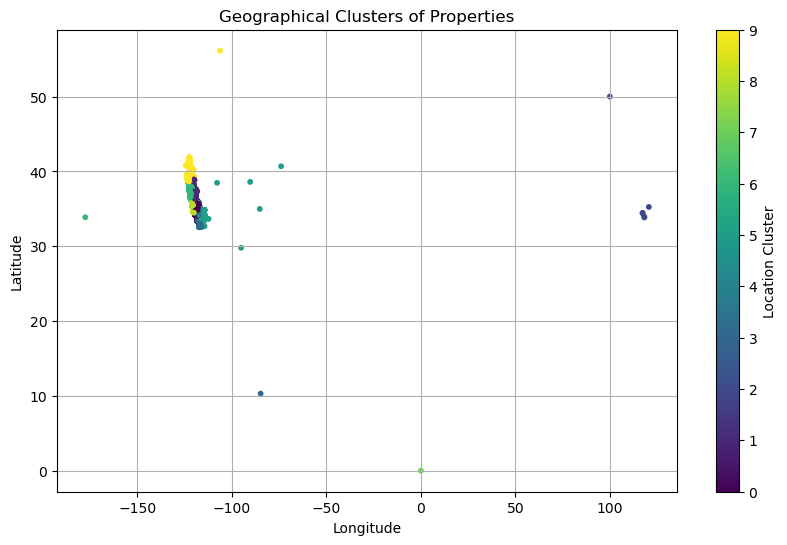

In [29]:
clusters = sold_df_5.loc[coords.index,'LocationCluster']

plt.figure(figsize = (10,6))
scatter = plt.scatter(coords['Longitude'], coords['Latitude'], c = clusters, cmap = 'viridis', s = 10)
plt.colorbar(scatter, label='Location Cluster')
plt.xlabel('Longitude') 
plt.ylabel('Latitude')
plt.title('Geographical Clusters of Properties')
plt.grid(True)
plt.show()

Based on the above plot, the dataset might contain the wrong dataset, which is outside of California. 

Since this project is only focusing in the data from California, I will drop rows which contain the outside of California in terms of `Latitude` or `Longitude`.  

In [30]:
# Define California bounds
lat_min, lat_max = 32.5, 42.0
lon_min, lon_max = -124.5, -114.0

# Rows outside California
outside_ca = sold_df_5[
    (~sold_df_5['Latitude'].between(lat_min, lat_max)) |
    (~sold_df_5['Longitude'].between(lon_min, lon_max))
]

outside_ca


,Flooring,CloseDate,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,ListAgentFullName,CountyOrParish,...,AttachedGarageYN_False,AttachedGarageYN_Missing,AttachedGarageYN_True,FireplaceYN_False,FireplaceYN_Missing,FireplaceYN_True,NewConstructionYN_False,NewConstructionYN_Missing,NewConstructionYN_True,LocationCluster
10183,NaN,2024-04-05,196000.0,29.794143,-95.149214,1034 Maclesby,Residential,1106.0,Cynthia Jauregui,Other State,...,0,0,1,0,0,1,1,0,0,5.0
11924,"Carpet,Tile",2024-04-24,422750.0,33.658134,-112.393471,15450 W MIRAMONTE Court,Residential,1894.0,Michael Szymanski,Other State,...,0,0,1,1,0,0,1,0,0,5.0
16853,NaN,2024-05-09,315000.0,50.000000,100.000000,1999 Highland Drive,Residential,892.0,Alicia Zamora,Merced,...,1,0,0,1,0,0,1,0,0,2.0
18980,NaN,2024-05-13,425000.0,34.475681,117.372126,13346 Crystal Court,Residential,1673.0,Britton Nealeigh,San Bernardino,...,0,0,1,0,0,1,1,0,0,2.0
20630,NaN,2024-05-02,805000.0,33.852530,118.251830,1129 E Gladwick Street,Residential,1822.0,Michael Salas,Los Angeles,...,0,0,1,0,0,1,1,0,0,2.0
21283,"Carpet,Tile",2024-05-17,201000.0,34.984405,-85.282577,306 E Gordon Avenue,Residential,1536.0,Sara Manalac,Other State,...,0,1,0,1,0,0,1,0,0,5.0
25943,"Carpet,SeeRemarks,Tile",2024-05-14,1994637.0,35.251598,120.634389,4027 Hillside Drive,Residential,2922.0,Mike Hixson,San Luis Obispo,...,0,0,1,0,0,1,0,0,1,2.0
26059,NaN,2024-05-13,3650000.0,10.305220,-84.810691,0 Monte Verde & 7th SWC Street,Residential,2506.0,Tim Allen,Monterey,...,0,0,1,0,0,1,1,0,0,3.0
38751,"Tile,Wood",2024-06-18,305000.0,56.130366,-106.346771,10346 Brookside Drive,Residential,742.0,Timothy Toye,Lake,...,0,1,0,0,0,1,1,0,0,9.0
46823,Wood,2024-07-19,4600000.0,40.688808,-73.975784,29 S Elliott Place,Residential,NaN,Magnus Hellberg,Other County,...,0,1,0,0,0,1,1,0,0,5.0


In [31]:
sold_df_6 = sold_df_5.drop(index = outside_ca.index, errors = 'ignore')

sold_df_6.shape


(75765, 47)

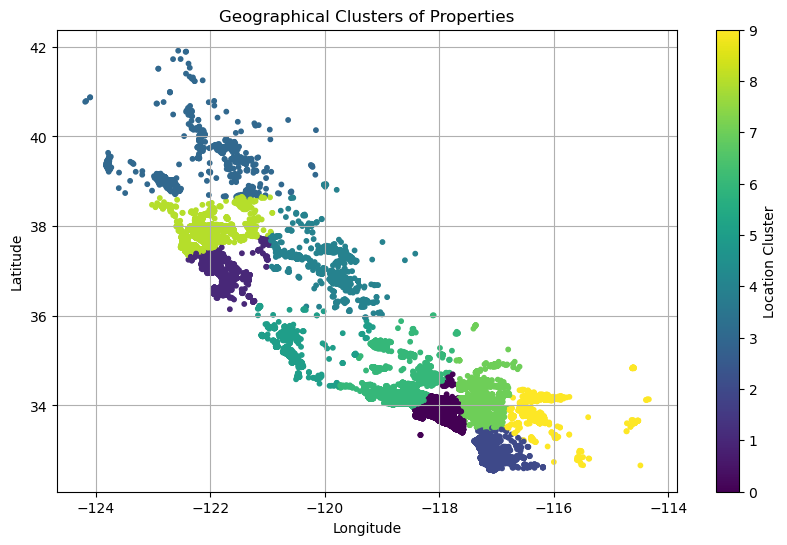

In [32]:

coords = sold_df_6[['Latitude', 'Longitude']].dropna()
kmeans = KMeans(n_clusters = 10, random_state = 42).fit(coords)
sold_df_6.loc[coords.index, 'LocationCluster'] = kmeans.labels_

clusters = sold_df_6.loc[coords.index, 'LocationCluster']

plt.figure(figsize = (10,6))
scatter = plt.scatter(coords['Longitude'], coords['Latitude'], c = clusters, cmap = 'viridis', s = 10)
plt.colorbar(scatter, label = 'Location Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Clusters of Properties')
plt.grid(True)
plt.show()

##### Stakeholder Interpretation


The above scatter plot shows distinct groupings of properties, each colored differently. You can see that the algorithm has segmented the region into 10 clusters, effectively grouping houses by locaiton. For instance, one cluster might represent homes in the **San Diego area**, another cluster for **Los Angels metro**, depending on our data spread in Sourthern California. This confirms that **locaiton is being captured** in a meaningful way: naerby properties fall into the same cluster. In my model, instead of raw coordinates, using `LocationCluster` as a feature will allow me to account for location-based price differences.

In [33]:
sold_df_6.isnull().sum()[sold_df_6.isnull().sum() > 0]

sold_df_6.isnull().sum()[sold_df_6.isnull().sum() > 0].sort_values(ascending = False)

Flooring                 26607
Stories                  11727
Levels                    9378
GarageSpaces              2575
LotSizeSquareFeet         1238
City                        77
YearBuilt                   55
LivingArea                  36
StreetNumberNumeric         17
BathroomsTotalInteger       17
ListAgentFullName            6
dtype: int64

Moreover, since the `ListAgentFullName` is inrelevant to predict the `ClosePrice`, I will drop to make the dataset clean. 

In [34]:
sold_df_7 = sold_df_6.drop(columns = 'ListAgentFullName', errors = 'ignore')

sold_df_7.isnull().sum()[sold_df_7.isnull().sum() > 0].sort_values(ascending = False)

Flooring                 26607
Stories                  11727
Levels                    9378
GarageSpaces              2575
LotSizeSquareFeet         1238
City                        77
YearBuilt                   55
LivingArea                  36
StreetNumberNumeric         17
BathroomsTotalInteger       17
dtype: int64

In [35]:
print(f"Levels unique values: {sold_df_7['Levels'].unique()}")

print(f"Stories unique values: {sold_df_7['Stories'].unique()}")

Levels unique values: ['Two' 'One' nan 'ThreeOrMore' 'ThreeOrMore,MultiSplit' 'MultiSplit'
 'Two,MultiSplit' 'One,Two' 'One,MultiSplit' 'One,Two,ThreeOrMore'
 'Two,ThreeOrMore,MultiSplit' 'Two,ThreeOrMore' 'One,ThreeOrMore'
 'One,Two,MultiSplit']
Stories unique values: [ 2.  1. nan]


The dataset inclues a column called `Levels` that describes how many floors a property has, using values like `One`, `Two`, or `ThreeOrMore`. However, these are **text-based and inconsistent**, which makes them difficult for modeling. 

###### Cleaning Approach

1. Map to Numeric Values:
- `One` to 1
- `Two` to 2
- `ThreeOrMore` to 3
- Any missing or unrecognized values to `NaN`

2. Fill Missing Values:
- After converting to numeric, I filled in missing values with the **median number of levels** to preserve consistency without introducing bias.

3. Removing Redundant Columns:
- Dropped the original `Levels` and `Stories` columns after cleaning, as they are now redundant or too inconsistent to use.


This step ensures that **floor count is treated as a numerical features**, which is much more meanigful for machine learning models. It also avoids confusion from overlapping or inconsistent fields.

In [36]:

def map_levels(value):
    if pd.isna(value):
        return np.nan
    if 'ThreeOrMore' in value:
        return 3
    elif 'Two' in value:
        return 2
    elif 'One' in value:
        return 1
    else:
        return np.nan

sold_df_7['Levels_Clean'] = sold_df_7['Levels'].apply(map_levels)

median_level = sold_df_7['Levels_Clean'].median()
sold_df_7['Levels_Clean'] = sold_df_7['Levels_Clean'].fillna(median_level)


sold_df_8 = sold_df_7.drop(columns = ['Levels', 'Stories'], errors = 'ignore')

sold_df_8.isnull().sum()[sold_df_8.isnull().sum() > 0].sort_values(ascending = False)

Flooring                 26607
GarageSpaces              2575
LotSizeSquareFeet         1238
City                        77
YearBuilt                   55
LivingArea                  36
StreetNumberNumeric         17
BathroomsTotalInteger       17
dtype: int64

In [37]:
missing_cols = sold_df_8.columns[sold_df_8.isnull().sum() > 0]

sold_df_8[missing_cols].describe()

,LivingArea,YearBuilt,StreetNumberNumeric,BathroomsTotalInteger,GarageSpaces,LotSizeSquareFeet
count,75729.000000,75710.000000,7.574800e+04,75748.000000,73190.000000,7.452700e+04
mean,2028.016176,1975.240906,1.310548e+04,2.602775,2.030653,2.135961e+05
std,1120.730202,27.221113,4.474051e+05,1.115333,5.451692,1.148037e+07
min,0.000000,1801.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1371.000000,1955.000000,1.086000e+03,2.000000,2.000000,5.663000e+03
50%,1798.000000,1975.000000,3.539000e+03,2.000000,2.000000,7.233000e+03
75%,2416.000000,1997.000000,1.285800e+04,3.000000,2.000000,1.021450e+04
max,123764.000000,2025.000000,7.814782e+07,21.000000,600.000000,1.633500e+09


##### Handling Missing Values for Numerical Columns


In order to prepare for modeling, I will correclty handle missing values for numerical columns rather than dropping these records. 

By filling the missing values for `LivingArea`, `YearBuilt`, `BathroomsTotalInteger`, `GarageSpaces`, and `LotSizeSquareFeet`, I will use **median** to fill those missing values. 

By filling missing values with the median, I can avoid skewing the model toward luxury or oversized homes, and predictions remain more reliable for the majority of "normal" homes in the dataset.

In [38]:
sold_df_8['LivingArea'] = sold_df_8['LivingArea'].fillna(sold_df_8['LivingArea'].median())
sold_df_8['YearBuilt'] = sold_df_8['YearBuilt'].fillna(sold_df_8['YearBuilt'].median()) 
sold_df_8['BathroomsTotalInteger'] = sold_df_8['BathroomsTotalInteger'].fillna(sold_df_8['BathroomsTotalInteger'].median())
sold_df_8['GarageSpaces'] = sold_df_8['GarageSpaces'].fillna(sold_df_8['GarageSpaces'].median())   
sold_df_8['LotSizeSquareFeet'] = sold_df_8['LotSizeSquareFeet'].fillna(sold_df_8['LotSizeSquareFeet'].median()) 


However, since the `StreetNumberNumeric` shows the street number not other amenities features, filling by median doesn't make sense. 
Therefore, I will fill those missing values manually by using `UnparsedAddress` information. 

In [39]:
sold_df_8[sold_df_8['StreetNumberNumeric'].isna()][['Longitude', 'Latitude', 'UnparsedAddress', 'StreetNumberNumeric']]

,Longitude,Latitude,UnparsedAddress,StreetNumberNumeric
3014,-121.966135,36.978353,40th Avenue,NaN
5258,-121.871794,37.338720,16th St,NaN
15924,-122.147158,37.667679,16183 Via Harriet,NaN
17221,-121.921800,36.552600,Torres & 1st Street,NaN
20587,-121.983150,37.367925,Borax Drive,NaN
25117,-121.931217,36.601522,Buena Vista Avenue,NaN
26042,-121.966135,36.978353,40th Avenue,NaN
28461,-122.013750,37.531200,38293 Columbine Place,NaN
48154,-122.437868,37.476447,Grandview Boulevard,NaN
48627,-122.020729,36.982281,Hubbard Street,NaN


In [40]:
# 40th Avenue
mask_40th = sold_df_8['UnparsedAddress'].str.contains("40th Avenue", case=False, na=False)
sold_df_8.loc[mask_40th, 'StreetNumberNumeric'] = 40

# 16th St
mask_16th = sold_df_8['UnparsedAddress'].str.contains("16th St", case=False, na=False)
sold_df_8.loc[mask_16th, 'StreetNumberNumeric'] = 16

# 16183 Via Harriet
mask_via_harriet = sold_df_8['UnparsedAddress'].str.contains("16183 Via Harriet", case=False, na=False)
sold_df_8.loc[mask_via_harriet, 'StreetNumberNumeric'] = 16183

# Torres & 1st Street
mask_torres_1 = sold_df_8['UnparsedAddress'].str.contains("Torres & 1st", case=False, na=False)
sold_df_8.loc[mask_torres_1, 'StreetNumberNumeric'] = 0

# Borax Drive
mask_borax = sold_df_8['UnparsedAddress'].str.contains("Borax Drive", case=False, na=False)
sold_df_8.loc[mask_borax, 'StreetNumberNumeric'] = 0

# Buena Vista Avenue
mask_buena_vista = sold_df_8['UnparsedAddress'].str.contains("Buena Vista Avenue", case=False, na=False)
sold_df_8.loc[mask_buena_vista, 'StreetNumberNumeric'] = 0

# 38293 Columbine Place
mask_columbine = sold_df_8['UnparsedAddress'].str.contains("Columbine Place", case=False, na=False)
sold_df_8.loc[mask_columbine, 'StreetNumberNumeric'] = 38293

# Grandview Boulevard
mask_grandview = sold_df_8['UnparsedAddress'].str.contains("Grandview Boulevard", case=False, na=False)
sold_df_8.loc[mask_grandview, 'StreetNumberNumeric'] = 0

# Hubbard Street
mask_hubbard = sold_df_8['UnparsedAddress'].str.contains("Hubbard Street", case=False, na=False)
sold_df_8.loc[mask_hubbard, 'StreetNumberNumeric'] = 0

# Calle De Los Agrinemsors
mask_calle = sold_df_8['UnparsedAddress'].str.contains("Calle De Los Agrinemsors", case=False, na=False)
sold_df_8.loc[mask_calle, 'StreetNumberNumeric'] = 0

# California Street
mask_california = sold_df_8['UnparsedAddress'].str.contains("California Street", case=False, na=False)
sold_df_8.loc[mask_california, 'StreetNumberNumeric'] = 0

# Hidden Valley Road 1
mask_hidden_valley = sold_df_8['UnparsedAddress'].str.contains("Hidden Valley Road 1", case=False, na=False)
sold_df_8.loc[mask_hidden_valley, 'StreetNumberNumeric'] = 0

# Corral de Tierra
mask_corral = sold_df_8['UnparsedAddress'].str.contains("Corral de Tierra", case=False, na=False)
sold_df_8.loc[mask_corral, 'StreetNumberNumeric'] = 0

# 39 W. Shore Road
mask_wshore = sold_df_8['UnparsedAddress'].str.contains("39 W. Shore", case=False, na=False)
sold_df_8.loc[mask_wshore, 'StreetNumberNumeric'] = 39

# Blueberry Drive
mask_blueberry = sold_df_8['UnparsedAddress'].str.contains("Blueberry Drive", case=False, na=False)
sold_df_8.loc[mask_blueberry, 'StreetNumberNumeric'] = 0

# 991 76th Ave.
mask_76th = sold_df_8['UnparsedAddress'].str.contains("991 76th", case=False, na=False)
sold_df_8.loc[mask_76th, 'StreetNumberNumeric'] = 991


In [41]:
sold_df_8.isnull().sum()[sold_df_8.isnull().sum() > 0].sort_values(ascending = False)

Flooring    26607
City           77
dtype: int64

In [42]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'real_estate_city_fill')

def get_city(lat, lon):
    try:
        location = geolocator.reverse((lat,lon), timeout = 10)
        address = location.raw.get('address', {})
        return address.get('city') or address.get('town') or address.get('village') or address.get('hamlet')
    except:
        return None

In [43]:
mask_missing_city = sold_df_8['City'].isna()

sold_df_8.loc[mask_missing_city, 'City'] = sold_df_8[mask_missing_city].apply(
    lambda row: get_city(row['Latitude'], row['Longitude']), axis = 1)

In [44]:
sold_df_8[sold_df_8['City'].isna()][['Latitude', 'Longitude', 'UnparsedAddress', 'City']]

,Latitude,Longitude,UnparsedAddress,City
6401,34.656780,-118.384951,42636 Cabin Road,None
9879,33.291621,-116.968754,31872 Colby Ln,None
12322,38.834055,-121.025862,4630 Pilot Creek Ln,None
12659,37.394694,-121.447893,20200 Del Puerto Canyon Road,None
13525,36.545397,-121.733201,21 Calera Canyon Road,None
31010,36.563212,-121.721484,14180 Vereda Del Portal,None
36380,36.203762,-119.794270,18767 King Avenue,None
38498,33.694465,-117.626983,18442 Boulder Bluff,None
41770,36.870089,-121.646191,579 Carpenteria Road,None
50027,34.143015,-115.927473,79475 El Paseo Drive,None


In [45]:
# 42636 Cabin Road — Lancaster, CA
mask_cabin = sold_df_8['UnparsedAddress'].str.contains("Cabin Road", case=False, na=False)
sold_df_8.loc[mask_cabin, 'City'] = "Lancaster"

# 31872 Colby Ln — Escondido, CA
mask_colby = sold_df_8['UnparsedAddress'].str.contains("Colby Ln", case=False, na=False)
sold_df_8.loc[mask_colby, 'City'] = "Escondido"

# 4630 Pilot Creek Ln — Pilot Hill, CA
mask_pilot = sold_df_8['UnparsedAddress'].str.contains("Pilot Creek", case=False, na=False)
sold_df_8.loc[mask_pilot, 'City'] = "Pilot Hill"

# 20200 Del Puerto Canyon Road — Patterson, CA
mask_delpuerto = sold_df_8['UnparsedAddress'].str.contains("Del Puerto", case=False, na=False)
sold_df_8.loc[mask_delpuerto, 'City'] = "Patterson"

# 21 Calera Canyon Road — Salinas, CA
mask_calera = sold_df_8['UnparsedAddress'].str.contains("Calera Canyon", case=False, na=False)
sold_df_8.loc[mask_calera, 'City'] = "Salinas"

# 14180 Vereda Del Portal — Salinas, CA
mask_vereda = sold_df_8['UnparsedAddress'].str.contains("Vereda Del Portal", case=False, na=False)
sold_df_8.loc[mask_vereda, 'City'] = "Salinas"

# 18767 King Avenue — Lemoore, CA
mask_king = sold_df_8['UnparsedAddress'].str.contains("King Avenue", case=False, na=False)
sold_df_8.loc[mask_king, 'City'] = "Lemoore"

# 18442 Boulder Bluff — Trabuco Canyon, CA
mask_boulder = sold_df_8['UnparsedAddress'].str.contains("Boulder Bluff", case=False, na=False)
sold_df_8.loc[mask_boulder, 'City'] = "Trabuco Canyon"

# 579 Carpenteria Road — Aromas, CA
mask_carpenteria = sold_df_8['UnparsedAddress'].str.contains("Carpenteria Road", case=False, na=False)
sold_df_8.loc[mask_carpenteria, 'City'] = "Aromas"

# 79475 El Paseo Drive — Twentynine Palms, CA
mask_paseo = sold_df_8['UnparsedAddress'].str.contains("El Paseo Drive", case=False, na=False)
sold_df_8.loc[mask_paseo, 'City'] = "Twentynine Palms"

# 4309 Eucalyptus Road — Sacramento, CA
mask_eucalyptus = sold_df_8['UnparsedAddress'].str.contains("Eucalyptus Road", case=False, na=False)
sold_df_8.loc[mask_eucalyptus, 'City'] = "Sacramento"

# 80775 Indian Trail — Twentynine Palms, CA
mask_indiantrail = sold_df_8['UnparsedAddress'].str.contains("Indian Trail", case=False, na=False)
sold_df_8.loc[mask_indiantrail, 'City'] = "Twentynine Palms"

# 3570 La Honda Road — La Honda, CA
mask_lahonda = sold_df_8['UnparsedAddress'].str.contains("La Honda Road", case=False, na=False)
sold_df_8.loc[mask_lahonda, 'City'] = "La Honda"

# 2450 Miller Valley Rd — Campo, CA
mask_miller = sold_df_8['UnparsedAddress'].str.contains("Miller Valley", case=False, na=False)
sold_df_8.loc[mask_miller, 'City'] = "Campo"


In [46]:
sold_df_8.isnull().sum()[sold_df_8.isnull().sum() > 0].sort_values(ascending = False)

Flooring    26607
dtype: int64

The `Flooring` column originally contains **free-text descriptions** with multiiple materials listed per home, often with inconsistent formatting or rare types. 
To make this feature usable in my model, I created a new column, `Flooring_Simplified`.

1. Split and Normalize
- I split multiiple flooring types and removed extra spaces
- Example: `Carpte, Wood, Unknown` to `Carpet, Wood`

2. Keep Column Materials Only 
- I focused on the most frequently used and meaningful flooring types, such as `Carpet`, `Tile`, `Wood`, `Laminate`, `Vinyl`, `Stone`, `Concrete`, `Bamboo`, and `SeeRemarks`.

3. Group Rare Types
- Any flooring types not in the list were grouped into `Other` for simplicity.

4. Handle Missing Values
- If flooring infor was missing, I labeled it as `Unknown`.

After that, I dropped the original `Flooring` column, which was too messy and inconsistent to use directly.

In [47]:
def simplify_flooring(floor_str):
    if pd.isna(floor_str):
        return 'Unknown'
    types = floor_str.split(',')
    types = [t.strip() for t in types]
    
    # Keep only common ones
    common_types = ['Carpet', 'Tile', 'Wood', 'Laminate', 'Vinyl', 'Stone', 'SeeRemarks', 'Concrete', 'Bamboo']
    filtered = [t for t in types if t in common_types]
    return ','.join(sorted(set(filtered))) if filtered else 'Other'

In [48]:
sold_df_8['Flooring_Simplified'] = sold_df_8['Flooring'].apply(simplify_flooring)

sold_df_9 = sold_df_8.drop(columns = 'Flooring')

In [49]:
if sold_df_9.isnull().sum().any():
    print("There are still missing values in the dataset after processing.")
else:
    print("All missing values have been handled successfully.")

All missing values have been handled successfully.


After completing all data cleaning, I ran a final check to confirm that **no missing values remain** in the dataset. 

### Exploratory Data Analysis (EDA)

Before building models, I performed EDA to understand key relationship in the data. This helps me validate intuition about what drives home prices and also sparks ideas for additional feature engineering.

In [50]:
sold_df_9 = sold_df_9.drop(columns = ['WaterfrontYN_False', 'BasementYN_False'])

numerical_cols = sold_df_9.select_dtypes(include=['number'])

closeprice_corr = numerical_cols.corr()['ClosePrice'].drop('ClosePrice')  

corr_table = closeprice_corr.to_frame().rename(columns={'ClosePrice': 'CorrelationWithClosePrice'})

corr_table = corr_table.sort_values(by='CorrelationWithClosePrice', ascending=False)

corr_table

,CorrelationWithClosePrice
LivingArea,0.370295
BathroomsTotalInteger,0.362739
BedroomsTotal,0.212701
PoolPrivateYN_Missing,0.168198
FireplaceYN_True,0.119483
Levels_Clean,0.094277
PoolPrivateYN_True,0.067266
BasementYN_True,0.058659
Latitude,0.031796
ViewYN_True,0.029758


#### Feature Correlation with Close Price

To better understand which numeric features have the strongest influence on home prices, I computed **Pearson correlation coefficients** between each numerical column and the target variable. 

**Insights**

- **Large Homes** (`LivingArea`) and **more bathrooms/bedrooms** are strongly associated with higher sale prices.
- Interestingly, `PoolPrivateYN_Missing` has a positive correlation, possibly because many luxury homes omitted this field, or it's a data artfact.
- `FireplaceYN_True` also has a moderate positive impact, suggesting fireplaces may add appeal or indicate upscale homes.

- Homes **without pools or fireplaces** tend to sell for less, reinforcing the value of these amenities.
- `LocationCluster` and `Longitude` show moderate negative correlations, implying **some geographic areas (inland or rural)** may have lower prices.
- Many other features show **weak correlation individually**, but may still add value in combination or through interaction effects. 


###### Interpretation for Stakeholders

1. **Size and layout drive value**
- Larger homes with more bathrooms consistently sell for more.
2. **Luxury indicators matter**
- Pools, fireplaces, and possibly basements add value, or their absence subtracts value.
3. **Location still critical**
- Cluster/geographic coordinates affect price, though not captured fully by simple correlation.

In [51]:
sold_df_9['ClosePrice'].describe()

count    7.576500e+04
mean     1.293827e+06
std      2.077821e+06
min      3.450000e+02
25%      6.362150e+05
50%      9.200000e+05
75%      1.500000e+06
max      3.750000e+08
Name: ClosePrice, dtype: float64

In order to capture the features from `ClosePrice`, I plotted it as a histogram. 

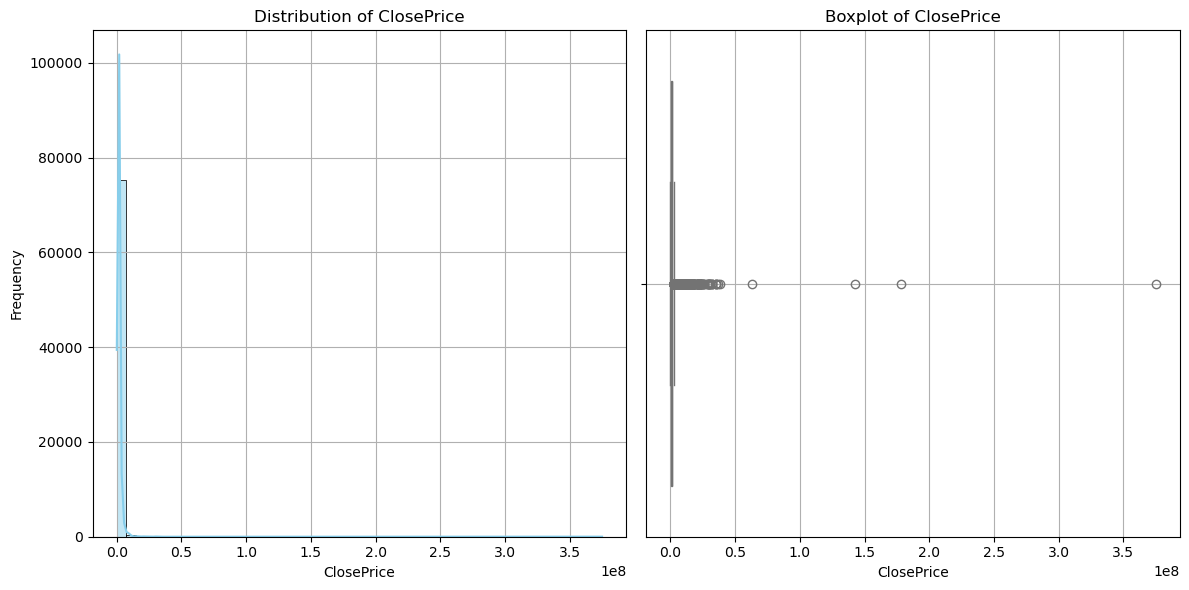

In [52]:

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(sold_df_9['ClosePrice'], kde=True, bins=50, color = 'skyblue')
plt.title('Distribution of ClosePrice')
plt.xlabel('ClosePrice')
plt.ylabel('Frequency') 
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x=sold_df_9['ClosePrice'], color='lightgreen')
plt.title('Boxplot of ClosePrice')
plt.xlabel('ClosePrice') 
plt.grid(True)
plt.tight_layout()
plt.show()


As you can see, the plot looks ugly because of the affection from outliers. In the real estate industry, it's impossible to predict outliers, so I decided to drop top 1% of `ClosePrice` to improve effectivity of analyzing and predicitng it. 

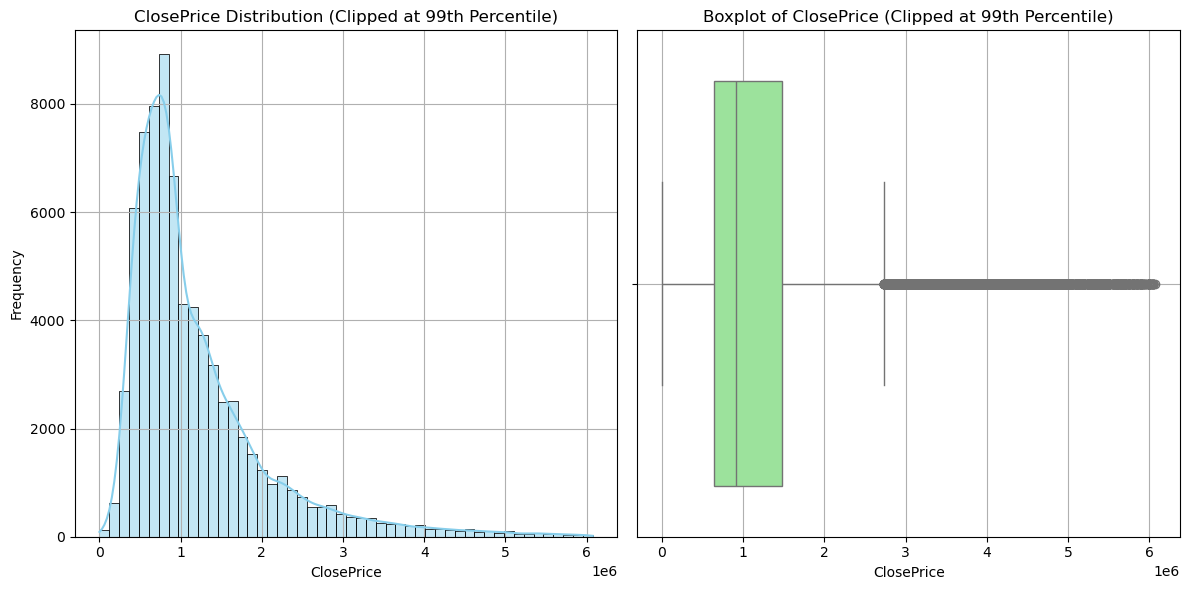

In [53]:
threshold = sold_df_9['ClosePrice'].quantile(0.99)
filtered_df = sold_df_9[sold_df_9['ClosePrice'] < threshold]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(filtered_df['ClosePrice'], bins=50, kde=True, color='skyblue')
plt.title('ClosePrice Distribution (Clipped at 99th Percentile)')
plt.xlabel('ClosePrice')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_df['ClosePrice'], color='lightgreen')    
plt.title('Boxplot of ClosePrice (Clipped at 99th Percentile)')
plt.xlabel('ClosePrice')    
plt.grid(True)
plt.tight_layout()
plt.show()

After removing the top 1%, the **distribution of home prices** becomes much more reasonable and easier to model. In the histogram, we see that most homes cluster at lower price ranges (with a peak perhaps in the few hundred-thousand dollar range), and the distribution tapers off as prices increase. The long tail of ultra-expensive properties is effectively gone. The accompanying boxplot shows that the spread of prices: the median sale price (middle line in the box) and the interquartile range are clearly visible, and while there are still some outliers (dots beyond the whiskers), they are far less extreme than before. This step ensures my analysis and models aren't dominated by a tiny fraction of atypical data points.

Now my cleaned dataset (`filtered_df`) is ready for deeper exploration and modeling. 
It contains the vast majority of homes and sans the extreme outliers.

In [54]:
filtered_df.groupby('BathroomsTotalInteger')['ClosePrice'].count().sort_values(ascending=False)

BathroomsTotalInteger
2.0     32955
3.0     25070
1.0      7322
4.0      5973
5.0      2420
6.0       891
7.0       235
8.0        64
9.0        34
0.0        27
10.0        9
12.0        3
11.0        1
16.0        1
20.0        1
Name: ClosePrice, dtype: int64

**Price Distribution by Property Characteristics**

I examined how sale prices vary with certain features.
First, I explored the relationship between `ClosePrice` and `BathroomsTotalInteger` by using KDE plot. 

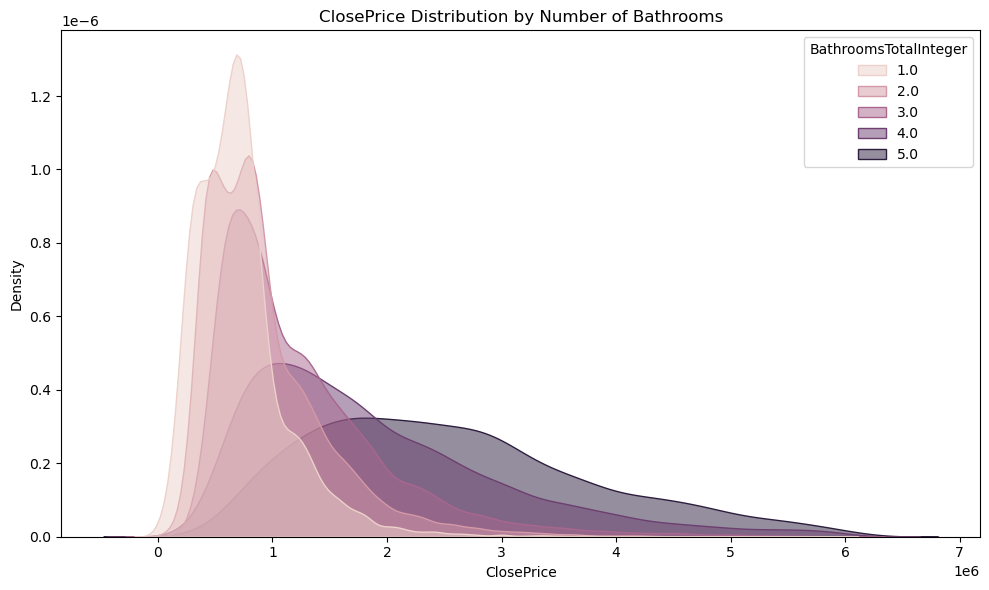

In [55]:
top_5_bathcounts = [1.0, 2.0, 3.0, 4.0, 5.0]
filtered_df = filtered_df[filtered_df['BathroomsTotalInteger'].isin(top_5_bathcounts)]


plt.figure(figsize = (10,6))
sns.kdeplot(data = filtered_df, x = 'ClosePrice', hue = 'BathroomsTotalInteger', fill = True, common_norm = False, alpha = 0.5)
plt.title('ClosePrice Distribution by Number of Bathrooms')
plt.xlabel('ClosePrice')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

The plot above, each color represents homes goruped by the number of bathrooms. We can see a clear trend: houses with **more bathrooms** tend to have their price distribution shifted to the right (= Higher Prices). 

For instance, the density curve for homes with 1 bathrooms peaks much lower on the price axis compared to the curve for homes with 3 or 4 bathrooms. This aligns with expectations, more bathrooms usually means a larger and often more upscale home, thus commanding a higher price.
 
Business takeaway: *homes with more bathrooms generally sell for more*.

**Price vs Living Area**

Size is a fundamental driver of home value. I created a scatter plot to see the relationship between living area and price, also using color to dentoe bathroom count.

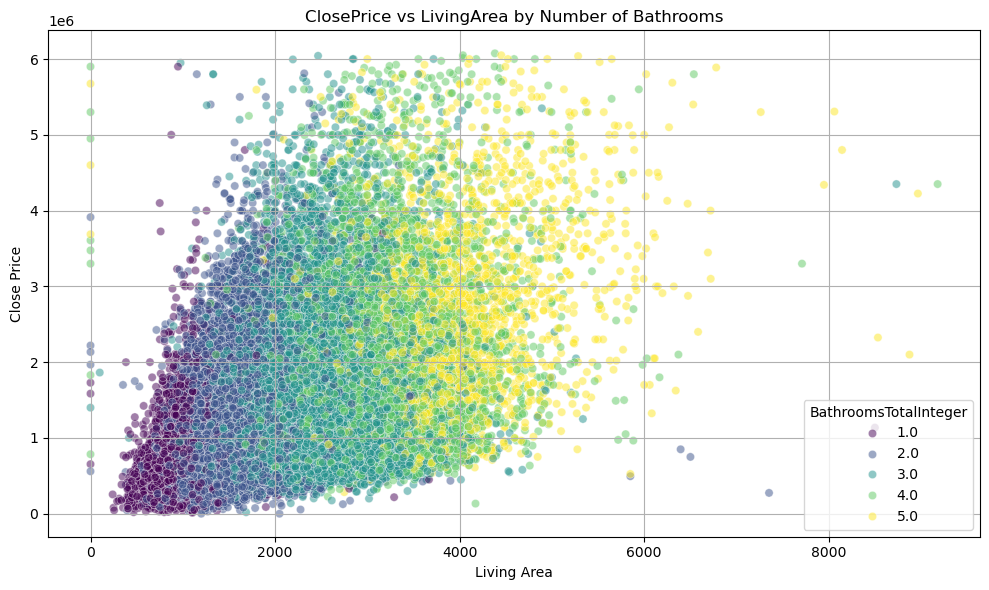

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='LivingArea', y='ClosePrice', hue = 'BathroomsTotalInteger', alpha=0.5, palette='viridis')
plt.title('ClosePrice vs LivingArea by Number of Bathrooms')
plt.xlabel('Living Area')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot reveals a **positive correlation** between living area and price – the points slope upward, indicating larger homes generally fetch higher prices. Notably, the points are color-coded by number of bathrooms: larger homes (toward the right of the plot) often have more bathrooms (shown by, for example, darker points if darker color corresponds to higher bathroom count). We can see clustering of high-bathroom-count homes in the upper-right region (big, expensive houses), whereas homes with fewer bathrooms cluster towards the lower-left (small, cheaper houses). The relationship isn’t perfectly linear (as expected, since other factors like location also play a big role), but the overall trend confirms bigger homes cost more. This underscores to stakeholders that **square footage is a key value driver** – something to always consider in pricing.

**Price Variation by City**

Location is critical in real estate.
I looked at the distribution of prices in the top cities in my dataset.

In [57]:
filtered_df.groupby('City')['ClosePrice'].count().sort_values(ascending = False)

City
Los Angeles        2573
San Diego          2429
San Jose           2188
Riverside          1132
Oakland             934
                   ... 
Earlimart             1
Auburn                1
Atwater Village       1
Ripley                1
El Mirage             1
Name: ClosePrice, Length: 911, dtype: int64

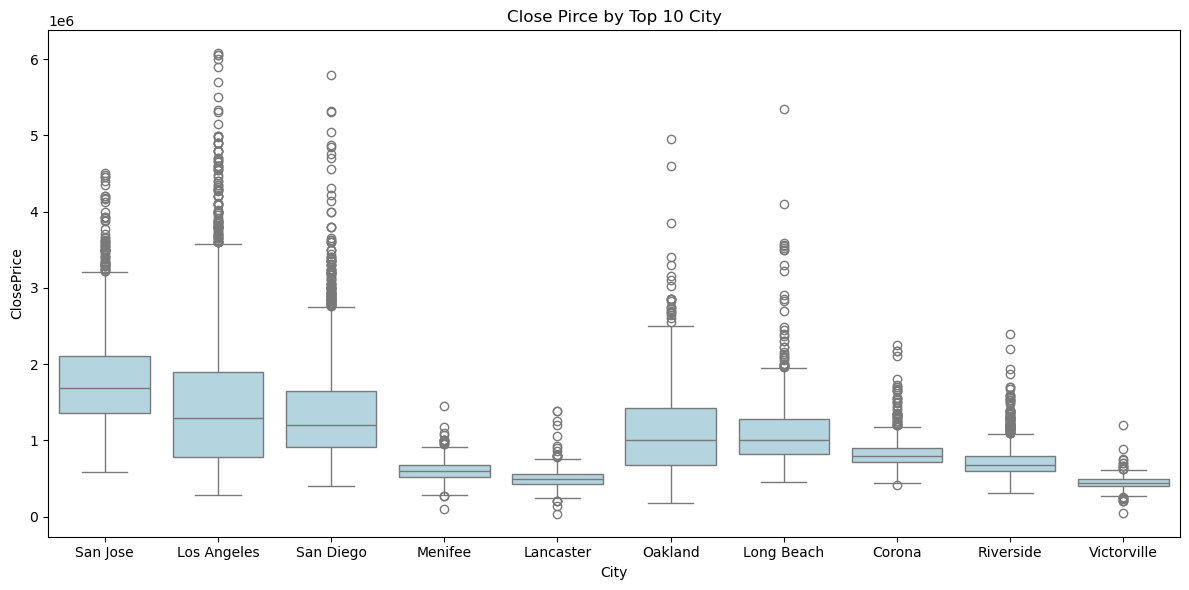

In [58]:
top_city = filtered_df['City'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.boxplot(data =filtered_df[filtered_df['City'].isin(top_city)], x = 'City', y = 'ClosePrice', color = 'lightblue')
plt.title('Close Pirce by Top 10 City')
plt.tight_layout()
plt.show()

The boxplot above compares sales prices across the 10 cities with the most sales in our data. Each city has a box showisng the median sale price and the interquartile range, with whiskers and potential outliers beyound them. I observe that **median prices differ markedlly by city**. For example, one city's box might be significantly higher on the y-axis than another's, indicating it's a pricier market. Tje spread (box height and whiskers) also indicates variability, some cities have a tight price range, while others have a wide range (possibly a larger city with diverse neighborhoods). This confirms the intuition that location strongly influences home prices. 

**Insights**

1. **High-Value Markets**
- **San Jose, Los Angels,** and **San Diego** stand out with the **highet median and upper-quartile prices**.
    - San Jose has the **highest median sale price** and a more compressed price range then LA.
    - Los Angels and San Diego show a wider range and **more luxury outliers**, suggesting more variability in home types. 
- These cities represent **premium markets** and likely contain both **high-end and mid-tier neighborhoods**.

2. **Mid-Tier Markets**
- **Oakland** and **Long Beach** have **moderate medians** and long tails of expensive properties. 
    - This indicates a **diverse housing market**: homes can range form starter-level to luxury, depending on the neighborhood.

3. **Affordable Markets**
- **Victorville, Lancaster**, and **Menifee** show the **lowest median home prices** and tight price ranges among these top 10 famous citites. 
    - These cities are likely more affordable suburban or rural areas with **limited high-end inventory**.
    - Less pricing volatility makes these cities more **predictable fro entry-level buyyers or investors**.


##### Business Implications for Stakeholders

- **Pricing Strategy**: Cities like San Jose and LA require pricing models due to their **wide price ranges and outliers**.
- **Target Market Planning**: Affordable cities like Victorville or Menifee may be attractive for **first-time homebuyers** or **developers targeting high turnover at lower price points**.
- **Investment Focus**: Mid-range cities with upward potential (like Oakland or Long Beach) may offer **better return on investment** with lower cost but room for appreciation.
- **Modeling Insight**: Including city as a categorical feature or using **location clusters** is essential, as geographic variance is one of the strongest predictors of home price. 

In [59]:
# Feature Engineering

filtered_df['LotPerLivingArea'] = filtered_df['LotSizeSquareFeet'] / filtered_df['LivingArea']

filtered_df['HasGarage'] = filtered_df['GarageSpaces'].apply(lambda x: 1 if x>0 else 0)

filtered_df['Has_Fireplace'] = filtered_df['FireplaceYN_True'].fillna(0).astype(int)

filtered_df['Is_New'] = filtered_df['YearBuilt'].apply(lambda x: 1 if x >= 2020 else 0)



In order to make a model is meaningful and reliable, I made four new features to support to gain the insights from my dataset. 
- `LotPerLivingArea`: Ratio of land size to home's interior space. This helps me identify whether a home sits on a large lot, which can increase value even if the house size itself is modest.
- `HasGarage`: A binary indicator for whether the home includes any garage space. Garage availability is a key amenity, especially in suburban or urban markets where parking is valuable.
- `Has_Fireplace`: A binary indicator for whether the home has a fireplace. Fireplaces can enhance a home's aesthetic appeal and comfort, especially in higher-end homes or colder regions.
- `Is_New`: A binary flag indicating whether the home was built in 2020 or later. Newer homes often come with modern layouts, energy efficiency, and require fewer repairs, making them more desirable and often more expensive.


These features aim to improve the model's ability to **capture lifestyle-related value drivers**, not just raw size or location. They help translate practical real estate insights into **predictive signals** the model can leran from.

**Distance to City Centers**

I introduced features measuring how far a property is from major city centers, hypothesizing that properties further from economic hubs might less expensive. For example, I computed each home's distance to downtown Los Angels, San Diego, and the other key city centers, and took the minimum as a feature (how far is this home from the nearest major city center). 

In [60]:
major_centers = {
    "Los Angeles": (34.0522, -118.2437),
    "San Francisco": (37.7749, -122.4194),
    "San Diego": (32.7157, -117.1611),
    "Sacramento": (38.5816, -121.4944),
    "San Jose": (37.3382, -121.8863),
    "Fresno": (36.7378, -119.7871)
}


In [61]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [62]:
def closest_major_city(lat, lon):
    min_city = None
    min_dist = float('inf')
    for city, (clat, clon) in major_centers.items():
        dist = haversine_distance(lat, lon, clat, clon)
        if dist < min_dist:
            min_dist = dist
            min_city = city
    return min_city, min_dist

# Apply function
filtered_df[['closest_city', 'distance_to_downtown']] = filtered_df.apply(
    lambda row: pd.Series(closest_major_city(row['Latitude'], row['Longitude'])), axis=1
)


In [63]:
filtered_df[['distance_to_downtown', 'closest_city', 'HasGarage', "Is_New", 'Has_Fireplace', 'LotPerLivingArea']].isnull().sum()



distance_to_downtown    0
closest_city            0
HasGarage               0
Is_New                  0
Has_Fireplace           0
LotPerLivingArea        0
dtype: int64

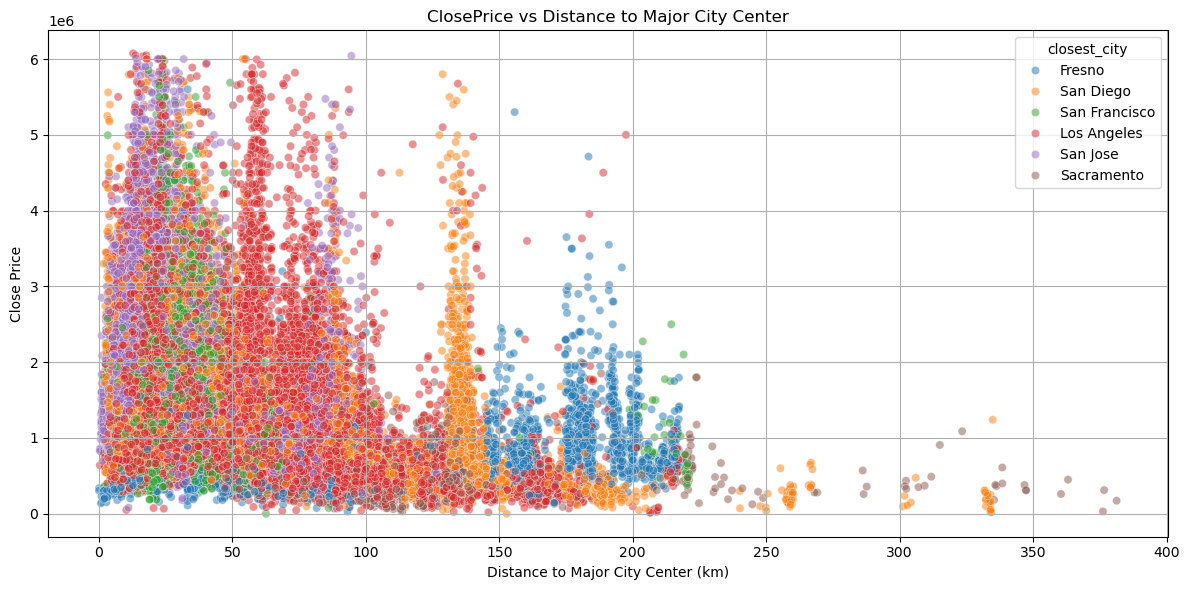

In [64]:
plt.figure(figsize = (12,6))
sns.scatterplot(data = filtered_df, x = 'distance_to_downtown', y = 'ClosePrice', hue = 'closest_city', alpha = 0.5)
plt.title('ClosePrice vs Distance to Major City Center')
plt.xlabel('Distance to Major City Center (km)')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot above (each point colored by which city it's closest to) shows that **price tends to decrease as distance from major cities increases**. Houses very close to a big city (left side of x-axis) include many high-priced points, whereas houses farther out (right side) are generally lower in price. This mathces the concept of "location, location, location": central locations often demand a premium, while peripheral areas are more affordable. Of course, there is overlap between cities, for instance being 20 km from Los Angels might still put you in a higly valued suburban area, whereas 20km from a smaller city might drop value more, but the overall pattern supports that **proximity to urban centers adds value.**

In [65]:
numerical_cols = filtered_df.select_dtypes(include = ['number']).columns

closeprice_corr = filtered_df[numerical_cols].corr()['ClosePrice'].drop('ClosePrice')

corr_table = closeprice_corr.to_frame().rename(columns = {'ClosePrice' : 'Correlation_With_ClosePrice'})

corr_table = corr_table.sort_values(by = 'Correlation_With_ClosePrice', ascending = False)

corr_table

,Correlation_With_ClosePrice
LivingArea,0.503682
BathroomsTotalInteger,0.461690
PoolPrivateYN_Missing,0.346112
BedroomsTotal,0.295447
FireplaceYN_True,0.232219
Has_Fireplace,0.232219
Levels_Clean,0.131841
HasGarage,0.115593
Latitude,0.104273
PoolPrivateYN_True,0.062733


Since more features will help to train machine learning models, I will create two more features which will help to train the models. 

In [66]:
filtered_df['TotalRooms'] = filtered_df['BathroomsTotalInteger'] + filtered_df['BedroomsTotal']

filtered_df['GarageSpaces_Per_LivingArea'] = filtered_df['GarageSpaces'] / filtered_df['LivingArea']

filtered_df[['TotalRooms', 'GarageSpaces_Per_LivingArea', 'ClosePrice']].corr()

,TotalRooms,GarageSpaces_Per_LivingArea,ClosePrice
TotalRooms,1.000000,-0.041045,0.421642
GarageSpaces_Per_LivingArea,-0.041045,1.000000,-0.029565
ClosePrice,0.421642,-0.029565,1.000000


**New Features**

- `TotalRooms`: Since both `BathroomsTotalInteger` and `BedroomsTotal` have strong positive correlation with `ClosePrice`, this new feature will help to gain the general ideas of the importance of numbers of rooms in the real estate.
- `GarageSpaces_Per_LivingArea`: While `GarageSpaces` has no strong correlaiton with `ClosePrice`, `HasGarage` which tells that the house whether owning a garage or not, have somewhat strong correlation. In addition, `LivingArea` is the most important feature so far to see the relationship of `ClosePrice`, see the trends of these two relationships is really important for future analysis.  

In [67]:
filtered_df['LivingArea'].describe()

count    73740.000000
mean      1936.211161
std        797.414828
min          0.000000
25%       1360.000000
50%       1772.000000
75%       2356.000000
max       9180.000000
Name: LivingArea, dtype: float64

I also want to create a new feature called `LargeLivingAreea_With_EnoughRoom` to capture the meaningful insights about `ClosePrice`. 

I set that the thresholds for `LivingArea` is over 75%, while `TotalRooms` set over 50%. 

In [68]:
# Calculate 75th percentile and 50th percentiile 
living_area_thresh = filtered_df['LivingArea'].quantile(0.75)
room_thresh = filtered_df['TotalRooms'].quantile(0.50)

# Create binary feature
filtered_df['LargeLivingArea_With_EnoughRoom'] = np.where((filtered_df['LivingArea'] > living_area_thresh) & (filtered_df['TotalRooms'] > room_thresh),1,0)

filtered_df[['LargeLivingArea_With_EnoughRoom', 'ClosePrice']].corr()


,LargeLivingArea_With_EnoughRoom,ClosePrice
LargeLivingArea_With_EnoughRoom,1.000000,0.389122
ClosePrice,0.389122,1.000000


As you can see, there is a strong positive correlation between `ClosePrice` and `LargeLivingArea_With_EnoughRoom`, which indicates that areas of house is really important indicators to predict the house price. 

In [69]:
filtered_df['LotPerLivingArea'] = filtered_df['LotPerLivingArea'].replace([np.inf, -np.inf], np.nan)


median_value = filtered_df['LotPerLivingArea'].median()
filtered_df['LotPerLivingArea'] = filtered_df['LotPerLivingArea'].fillna(median_value)


## Machine Learning Modeling


With a clean and feture-rich dataset prepared, I now shift to the core objective of this project: **Builiding a Machine Learning model that accurately predicts a property's final sale price** based on its characteristics. 

To create a predictive model that can estimate home values using features such as, property size, amenities, location, market factors.

Accurate price prediciton can: 
- Help sellers and agents **set competitive and realistic list prices**.
- Assist buyers in identifying **over or under-valued properties**.
- Support investors and analysts in making **data-driven real estate decisions**.

##### First Machine Learning Models

I trained three regression models to predict home prices using a carefully selected set of **property and location features**. These models help us assess how well different algorithms capture the relationship between home characteristics and final sale price.

**Features Used**
The model inputs include a mix of:
- **Size & Structure**: `LivingArea`, `BathroomsTotalInteger`, `BedroomsTotal`, `TotalRooms`, `LotSizesquareFeet`
- **Derived Features**: `LotPerLivingArea`, `Has_Fireplace`, `HasGarage`, `Is_New`, `LargeLivingArea_With_EnoughRoom`
- **Location Indicators**: `Latitude`, `Longitude`, `LocationCluster`, `distance_to_downtown`
- **Amenity Flags**: `BasementYN_True`, `PoolPrivateYN_True`, `FireplaceYN_True`, `ViewYN_True`
- **Age**: `YearBuilit`

Three models I used:
1. **Linear Regression**: A simple, interpretable baseline model assuming, linear relationships
2. **Random Forest**: An ensemble of decision trees that captures nonlinear patterns and interactions
3. **XGBoost**: A powerful gradient boosting algorithm, often top-performing on structured data

**Evaluation Metrics**

Each model was evaluated using: 
- **RMSE (Root Mean Squared Error)**: Average prediction error in dollars
- **MAPE (Mean Absolute Percentage Error)**: Average percentage error
- **R2 Score**: Variance in sale price explained by the model

In [70]:
features = [
    'LivingArea', 'BathroomsTotalInteger', 'BedroomsTotal',
    'LotSizeSquareFeet', 'LargeLivingArea_With_EnoughRoom',
    'LotPerLivingArea', 'Has_Fireplace', 'Is_New',
    'distance_to_downtown', 
    'Latitude', 'Longitude', 'YearBuilt',
    'LocationCluster', 'HasGarage', 
    'BasementYN_True', 'PoolPrivateYN_True',
    'FireplaceYN_True', 'ViewYN_True', 'TotalRooms'
]

X = filtered_df[features]
y = filtered_df['ClosePrice']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.2, max_depth=6, random_state=42)
lr = LinearRegression()

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train, y_train)

LinearRegression()

In [73]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate(model, X, y, name):
    preds = model.predict(X)
    rmse = mean_squared_error(y, preds, squared=False)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    print(f'{name} RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R_2: {r2:.2f}')

evaluate(lr, X_test, y_test, "Linear Regression")
evaluate(rf, X_test, y_test, "Random Forest")
evaluate(xgb, X_test, y_test, "XGBoost")

Linear Regression RMSE: 570140.96, MAPE: 45.49%, R_2: 0.52
Random Forest RMSE: 299373.79, MAPE: 20.21%, R_2: 0.87
XGBoost RMSE: 286538.00, MAPE: 20.98%, R_2: 0.88


After training three predictive models, I evaluated their performace on a 20% holdout test set. 

**Key Insights**

- **XGBoost outperformed all other models**, achieving the lowest RMSE and the highest R2 score, meaning it captured the most variation in home prices.
- **Random Forest** also performed very well, with a slightly higher RMSE but a lower MAPE (better average percentage accuracy), suggesting it's especially reliable across a wide price range.
- **Linear Regression**, while fast and interpretable, underperformed with an R2 score of just 0.52 and high errors rates, confirming that **price prediciton is not a simple linear problem**.


**Business Takeaways**

- Advanced models like **XGBoost and Random Forest** are **much better suited for real estate pricing**, as they handle **nonlinear patterns, feature interactions**, and outliers more effectively.
- With an average error around **20%**, these models are strong enough to support use cases like: 
    - Pricing guidance for agents.
    - Valuation checks for buyers.
    - Automated market analysis for investors.


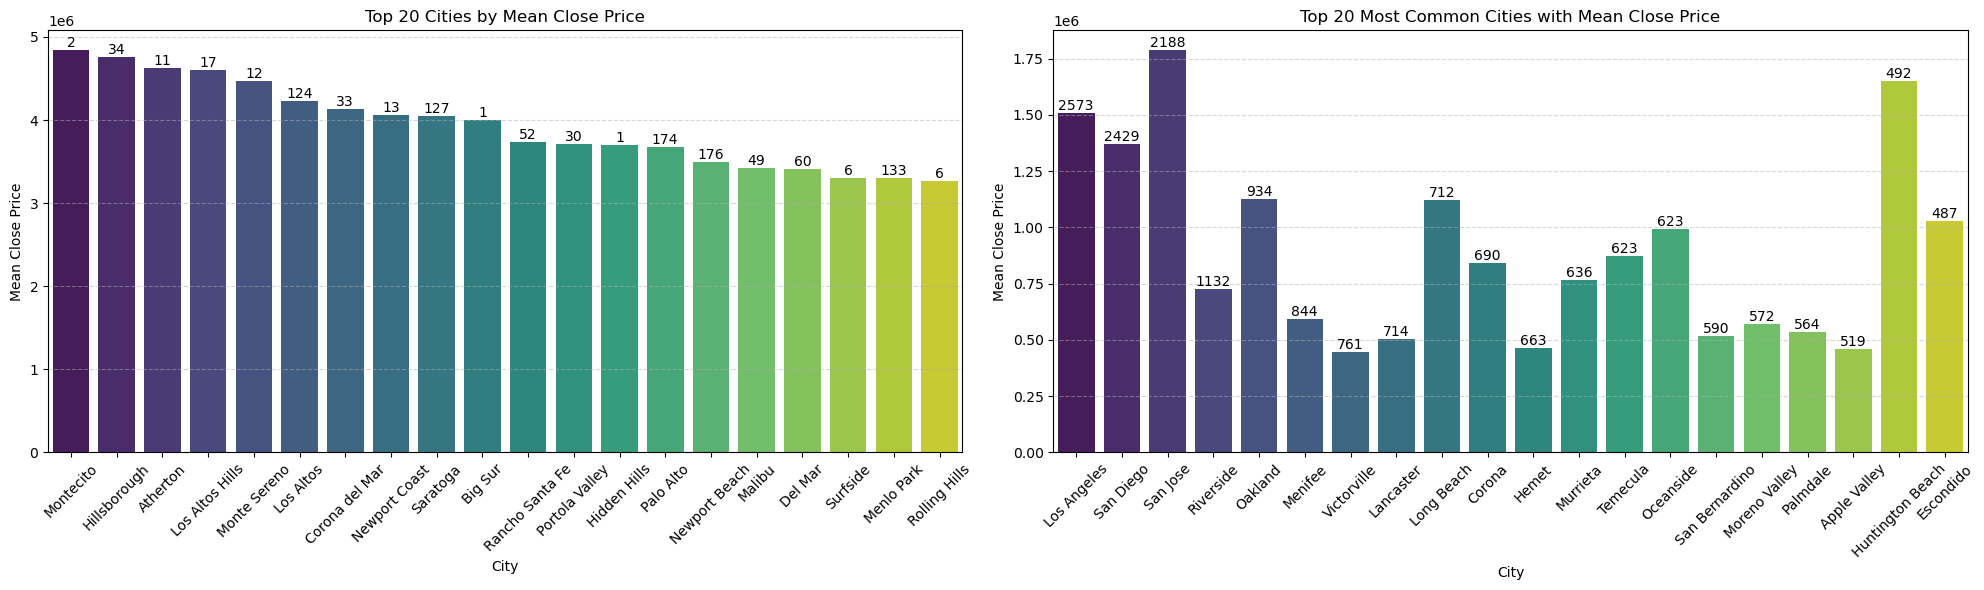

In [74]:
city_stats_Mean_price = (filtered_df.groupby('City').agg(MeanPrice=('ClosePrice', 'mean'), Frequency=('ClosePrice', 'count'))
    .sort_values(by='MeanPrice', ascending=False).head(20).reset_index())

city_stats_Frequency = (filtered_df.groupby('City').agg(MeanPrice=('ClosePrice', 'mean'), Frequency=('ClosePrice', 'count'))
    .sort_values(by='Frequency', ascending=False).head(20).reset_index())

fig, axes = plt.subplots(1, 2, figsize=(20, 6))


sns.barplot(ax=axes[0], data=city_stats_Mean_price, x='City', y='MeanPrice', palette='viridis')
axes[0].set_title('Top 20 Cities by Mean Close Price')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Mean Close Price')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

for index, row in city_stats_Mean_price.iterrows():
    axes[0].text(index, row['MeanPrice'], f"{row['Frequency']}", ha='center', va='bottom', fontsize=10)

sns.barplot(ax=axes[1], data=city_stats_Frequency, x='City', y='MeanPrice', palette='viridis')
axes[1].set_title('Top 20 Most Common Cities with Mean Close Price')
axes[1].set_xlabel('City')
axes[1].set_ylabel('Mean Close Price')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

for index, row in city_stats_Frequency.iterrows():
    axes[1].text(index, row['MeanPrice'], f"{row['Frequency']}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


The plot above contains two var chars side-by-side that compare California cities in terms of real estate prices and listing frequency.

**Left Plot: Top 20 Cities by Mean Close Price**
- **Montecito, Hillsborough**, and **Atherton** top the list with mean prices around$4.5-4.9 million.
- Some cities like **Portola Valley** and **Big Sur** have very few transactions (1 sale), which many skew the average.
- Wealthy tech hubs like **Palo Alot, Los Altos**, and **Menlo Park** are also represented. 
- Citites here tend to be **exclusive, luxury markets** with fewer but more expensive homes.

**Right Plot: Top 20 Most Common Cities with Mean Close Price**
- **Los Angels, San Diego**, and **San Jose** have the highest transaction volumes, showing their high market activity.
- These cities have **lower average prices (about $1M-1.8M)** compared to the left plot, likely due to more diverse housing stock. 
- This chart reflects **mainstream market behavior** more accurately than the left, which focuses on high-end anomalies.


**Key Takeaways for Stakeholders**
- **Segmented Strategy**
    - Use different approcahces for high-value luxury markets (left) vs high-volumne urban markets (right).
- **Risk vs Reach**
    - Left-chart cities offer higher price points but fewer deals; right-chart cities offer market breadth and repeatability.

Based on the insights from plot about city, I will make some new features which will help to improve the models.

In [75]:
mean_prices = filtered_df.groupby('City')['ClosePrice'].mean().sort_values(ascending = False)

top_100_expensive_cities = mean_prices.head(100).index

filtered_df['ExpensiveCity'] = filtered_df['City'].apply(lambda x: 1 if x in top_100_expensive_cities  else 0)

filtered_df[['ExpensiveCity', 'ClosePrice']].corr()

,ExpensiveCity,ClosePrice
ExpensiveCity,1.000000,0.592897
ClosePrice,0.592897,1.000000


**Description**:
- Identifies the **top 100 cities**  with the highest mean home prices.
- Creates a binary variable `ExpensiveCity`:
    - `1` if the porperty is located in one of these cities.
    - `0` otherwise.

**Purpose**:
- Captures the **location premium effect**, homes in more expensive cities generally sell for more.

**Use Case**:
- This feature can be useful in both **classification models** and **price prediciton** as a proxy for luxury market influence.

In [76]:
top_20_famous_cities = filtered_df['City'].value_counts().nlargest(20).index
living_area_top_20 = filtered_df['LivingArea'].quantile(0.80)

filtered_df['FamousCity_With_LargeHouse'] = filtered_df.apply(lambda row: 1 if (row['City'] in top_20_famous_cities and row['LivingArea'] >= living_area_top_20) else 0, axis = 1)


filtered_df[['FamousCity_With_LargeHouse', 'ClosePrice']].corr()

,FamousCity_With_LargeHouse,ClosePrice
FamousCity_With_LargeHouse,1.000000,0.103432
ClosePrice,0.103432,1.000000


**Desription**:
- Identifies the **20 most frequently listed cities** (highest transaction volume). 
- Computes the **80th percentile threshold** for `LivingArea`.
- Creates a binary variable `FamousCity_With_LargeHouse`: 
    - `1` if the property is in a high-volume city **and** has a large living area.
    - `0` otherwise.

**Purpose**:
- Highlights **prime real estate** in active markets, potentially representing desirable, spacious homes in populous areas.

**Use Case**:
- This can improve model performance by focusing **high-demand, large-property** segments of the market.

In [77]:
filtered_df_2 = filtered_df[filtered_df['LivingArea'] != 0]

filtered_df_2['TotalRoomsPerLivingArea'] = filtered_df_2['TotalRooms'] / filtered_df_2['LivingArea']

filtered_df_2[['TotalRoomsPerLivingArea', 'ClosePrice']].corr()

,TotalRoomsPerLivingArea,ClosePrice
TotalRoomsPerLivingArea,1.000000,-0.296866
ClosePrice,-0.296866,1.000000


**Desription**:
- Calcualtes **room density per squqre foot** by dividing `TotalRooms` bby `LivingArea`. 
- Removes entries where `LivingArea` is zero to avoid division errors.

**Purpose**:
- Quantifies how efficiently space is utilized in a home, high values may imply smaller or more compact spaces per room.

**Use Case**:
- This continuous feature can be insightful for models ot differntiate **luxury spacious homes** from **tight, low-end layouts**.

##### Second Machine Learning Models

From now, I will see what will happen in the second machine learning models after I added those new features which might be helpful to predict `ClosePrice`. 

In [78]:
features = ['LivingArea', 'BathroomsTotalInteger', 'BedroomsTotal',
    'LotSizeSquareFeet', 'LargeLivingArea_With_EnoughRoom',
    'LotPerLivingArea', 'Has_Fireplace', 'Is_New',
    'distance_to_downtown', 'Levels_Clean',
    'Latitude', 'Longitude', 'YearBuilt',
    'LocationCluster', 'HasGarage', 
    'PoolPrivateYN_False', 'TotalRooms',
    'TotalRoomsPerLivingArea', 'ExpensiveCity', 'FamousCity_With_LargeHouse',
    ]

X = filtered_df_2[features]
y = filtered_df_2['ClosePrice']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [80]:
rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.2, max_depth=6, random_state=42)
lr = LinearRegression()

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train, y_train)

LinearRegression()

In [81]:
evaluate(lr, X_test, y_test, "Linear Regression")
evaluate(rf, X_test, y_test, "Random Forest")
evaluate(xgb, X_test, y_test, "XGBoost")

Linear Regression RMSE: 449252.42, MAPE: 50.41%, R_2: 0.69
Random Forest RMSE: 276803.03, MAPE: 28.56%, R_2: 0.88
XGBoost RMSE: 272846.42, MAPE: 29.22%, R_2: 0.89


My second Machine Learnig Models, especially xgboost and random forest, increased MAPE despite better RMSE and R2 score.
This suggests the model became **less accurate in percentage terms** on **lower-priced homes**, even if it performs better overall in terms of RMSE.

**Interpretation**
- **RMSE is sensitive to large errors**, especially on expensive homes. The reduction in RMSE indicates the model improved its accuracy for high-priced properties.
- **MAPE is sensitive to small actual values**. If the model is making slightly larger percetage errors on **lower-priced homes**, MAPE increases, even if the dollar error is small.
- **R2 increasing** shows better overall variance explanation, but **not necessarily better error balance across price segments**.


**Potential Next Steps**

- Feature Engineers for low-priced houses:
    - Previously, I made some features which will capture the trend of high-priced house which helped me to improve the R2 socre and RMSE. However, my current model can't predict low-priced houses well since there are not enough parameter to predict those houses. Therefore, I shouold make some new features which can tell the trend from low-priced houses. 
- Error Analysis by Price Range:
    - Based on the low performance from MAPE, I'm guessing that I need to make some new features for low-priced houses since MAPE is sensitive to small actual values, but I should check whether my assumption is right or not through analysis.


##### New Features Engineering


1. For Low-Priced Houses:
    - `CheapCity`
        - Binary indicator for whether a property is located in one of the **100 cheapest cities** by mean close price.
    - `SmallLivingArea`
        - Flags hommes that fall in the **bottom 25%** of `LivingArea` distribution.
    - `HighRoomDensity`
        - Identifies homes with **dense layouts**, more rooms packed into a smaller space.
    - `CheapHighVolumeCity`
        - A binary feature that identifies cities that are:
            - Among the **top 50 cities** by transaction volumne
            - Have an **average `ClosePrice` in the bottom 40%** statewide.

In [82]:
mean_prices = filtered_df_2.groupby('City')['ClosePrice'].mean().sort_values()

top_100_cheap_cities = mean_prices.head(100).index

filtered_df_2['CheapCity'] = filtered_df_2['City'].apply(lambda x: 1 if x in top_100_cheap_cities else 0)

filtered_df_2[['CheapCity', 'ClosePrice']].corr()

,CheapCity,ClosePrice
CheapCity,1.000000,-0.122584
ClosePrice,-0.122584,1.000000


In [83]:
small_area_thresh = filtered_df_2['LivingArea'].quantile(0.25)

filtered_df_2['SmallLivingArea'] = (filtered_df_2['LivingArea'] < small_area_thresh).astype(int)

filtered_df_2[['SmallLivingArea', 'ClosePrice']].corr()

,SmallLivingArea,ClosePrice
SmallLivingArea,1.000000,-0.278052
ClosePrice,-0.278052,1.000000


In [84]:
room_density_thresh = filtered_df_2['TotalRoomsPerLivingArea'].quantile(0.5)

filtered_df_2['HighRoomDensity'] = (filtered_df_2['TotalRoomsPerLivingArea'] > room_density_thresh).astype(int)

filtered_df_2[['HighRoomDensity', 'ClosePrice']].corr()

,HighRoomDensity,ClosePrice
HighRoomDensity,1.000000,-0.256953
ClosePrice,-0.256953,1.000000


In [85]:
high_volume_cities = filtered_df_2['City'].value_counts().nlargest(50).index

avg_prices = filtered_df_2.groupby('City')['ClosePrice'].mean()

cheap_volume_cities = [city for city in high_volume_cities if avg_prices[city] <= avg_prices.quantile(0.40)]

filtered_df_2['CheapHighVolumeCity'] = filtered_df_2['City'].apply(lambda x: 1 if x in cheap_volume_cities else 0)

filtered_df_2[['CheapHighVolumeCity', 'ClosePrice']].corr()

,CheapHighVolumeCity,ClosePrice
CheapHighVolumeCity,1.000000,-0.294034
ClosePrice,-0.294034,1.000000


##### Error Analysis by Price Range

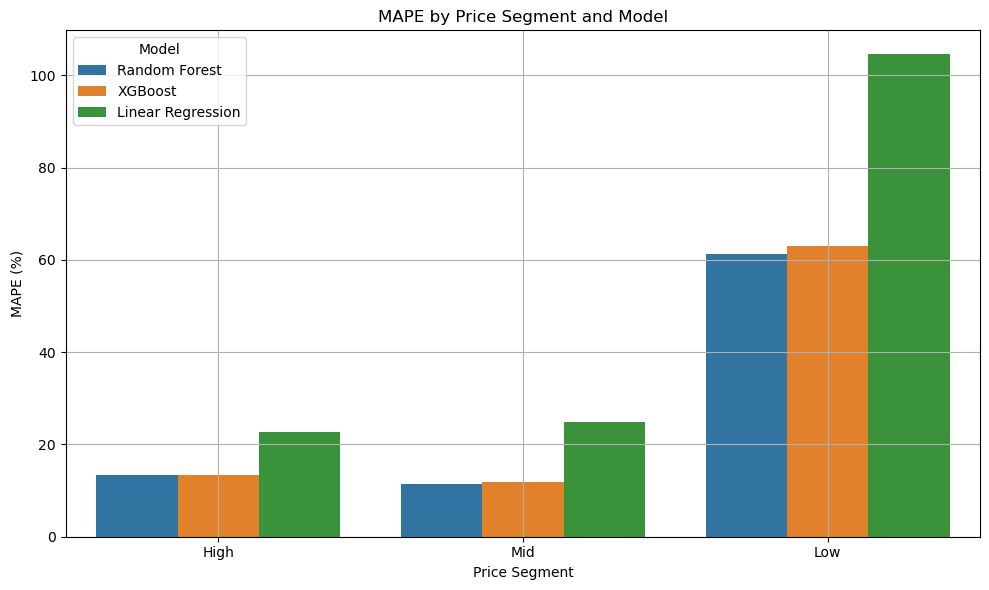

In [86]:
preds_rf = rf.predict(X_test)
preds_xgb = xgb.predict(X_test)
preds_lr = lr.predict(X_test)


error_df = pd.DataFrame({'Actual': y_test,'RF_Predicted': preds_rf, 'XGB_Predicted': preds_xgb,'LR_Predicted': preds_lr})

# Define price segments based on actual prices
low_thresh = error_df['Actual'].quantile(0.33)
high_thresh = error_df['Actual'].quantile(0.66)

def price_segment(price):
    if price <= low_thresh:
        return 'Low'
    elif price <= high_thresh:
        return 'Mid'
    else:
        return 'High'

error_df['PriceSegment'] = error_df['Actual'].apply(price_segment)

# Compute error metrics per model per price segment
def compute_segment_stats(model_col):
    return error_df.groupby('PriceSegment').apply(
        lambda g: pd.Series({
            'RMSE': np.sqrt(mean_squared_error(g['Actual'], g[model_col])),
            'MAPE': np.mean(np.abs((g[model_col] - g['Actual']) / g['Actual'])) * 100,
            'Count': len(g)
        })
    ).reset_index()

stats_rf = compute_segment_stats('RF_Predicted')
stats_rf['Model'] = 'Random Forest'

stats_xgb = compute_segment_stats('XGB_Predicted')
stats_xgb['Model'] = 'XGBoost'

stats_lr = compute_segment_stats('LR_Predicted')
stats_lr['Model'] = 'Linear Regression'

# Combine and plot
all_stats = pd.concat([stats_rf, stats_xgb, stats_lr])

# Specify custom order: High to Mid to Low
segment_order = ['High', 'Mid', 'Low']


plt.figure(figsize=(10, 6))
sns.barplot(data=all_stats, x='PriceSegment', y='MAPE', hue='Model', order = segment_order)
plt.title('MAPE by Price Segment and Model')
plt.ylabel('MAPE (%)')
plt.xlabel('Price Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

The chart above visualized the MAPE for each model across three price segments: Low, Mid, and High.

**Key Observations**

1. **Low Price Segment**:
    - All models struggle significantly here.
    - MAPE is above 60% for both Random Forest and XGBoost, and nearly 100% for Linear Regression.
    - This confirms that models have difficulty making accurate percentage-based predictions for **lower-priced models**.
    - Even small absolute errors can result in very large percentage errors in this segment.

2. **Mid Price Segment**:
    - MAPE drops significantly for all models.
    - **Tree-based models** maintain a low MAPE around **12-13%**.
    - **Linear Regression** remains less accurate, highlighting its limitations in capturing non-linear relationships. 

3. **High Price Segment**:
    - All models perform best here.
    - Random Forest and XGBoost both achieve MAPE values around **13-14%**.
    - Linear Regression again lags slightly, but performs better than in lower segments.

To further improve model performance and capture housing value drives, I made some additional features:
- `Age`
    - Calculates the **age of property** in years, from 2025.
- `BedBathRatio`
    - Computes the ratio of bedrooms to bathrooms
- `BathPerRoom`
    - Proportion of bathrooms to total rooms
- `ExpensiveCityWithPool`
    - Flags properties in expensive cities that also have a private pool.
- `NewInExpensiveCity`
    - Flags **newer homes (built after 2015)** located in **high-priced cities**.
- `Pool&Fireplace`
    - Binary flag for homes that feature **both a private pool and a fireplace**.
- `ExpensiveCity_With_LaregHouse`
    - Flags home in expensive cities that also have a **large living area**

In [87]:
filtered_df_2['Age'] = 2025 - filtered_df_2['YearBuilt']

filtered_df_2[['Age', 'ClosePrice']].corr()

,Age,ClosePrice
Age,1.00000,0.05908
ClosePrice,0.05908,1.00000


In [88]:
filtered_df_2['BedBathRatio'] = filtered_df_2['BedroomsTotal'] / filtered_df_2['BathroomsTotalInteger']
filtered_df_2['BedBathRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_df_2['BedBathRatio'].fillna(filtered_df_2['BedBathRatio'].median(), inplace=True)


filtered_df_2[['BedBathRatio', 'ClosePrice']].corr()

,BedBathRatio,ClosePrice
BedBathRatio,1.000000,-0.236037
ClosePrice,-0.236037,1.000000


In [89]:
filtered_df_2['BathPerRoom'] = filtered_df_2['BathroomsTotalInteger'] / filtered_df_2['TotalRooms']

median_bath_per_room = filtered_df_2['BathPerRoom'].median()


filtered_df_2['BathPerRoom'] = filtered_df_2['BathPerRoom'].fillna(median_bath_per_room)

filtered_df_2[['BathPerRoom', 'ClosePrice']].corr()

,BathPerRoom,ClosePrice
BathPerRoom,1.000000,0.256403
ClosePrice,0.256403,1.000000


In [90]:
filtered_df_2['ExpensiveCitywithPool'] = ((filtered_df_2['PoolPrivateYN_True'] == 1) & (filtered_df_2['ExpensiveCity'] ==1)).astype(int)

filtered_df_2[['ExpensiveCitywithPool', 'ClosePrice']].corr()

,ExpensiveCitywithPool,ClosePrice
ExpensiveCitywithPool,1.000000,0.195871
ClosePrice,0.195871,1.000000


In [91]:
filtered_df_2['NewinExpensiveCity'] = ((filtered_df_2['Age'] < 10) & (filtered_df_2['ExpensiveCity'] == 1)).astype(int)

filtered_df_2[['NewinExpensiveCity', 'ClosePrice']].corr()

,NewinExpensiveCity,ClosePrice
NewinExpensiveCity,1.00000,0.17907
ClosePrice,0.17907,1.00000


In [92]:
filtered_df_2['Pool&Fireplace'] = ((filtered_df_2['PoolPrivateYN_True'] == 1) & (filtered_df_2['FireplaceYN_True'] == 1)).astype(int)

filtered_df_2[['Pool&Fireplace', 'ClosePrice']].corr()

,Pool&Fireplace,ClosePrice
Pool&Fireplace,1.000000,0.082133
ClosePrice,0.082133,1.000000


In [93]:
living_area_thresh = filtered_df['LivingArea'].quantile(0.75)

filtered_df_2['ExpensiveCity_With_LargeHouse'] = ((filtered_df_2['ExpensiveCity'] == 1) & (filtered_df_2['LivingArea'] > living_area_thresh)).astype(int)

filtered_df_2[['ExpensiveCity_With_LargeHouse','ClosePrice']].corr()

,ExpensiveCity_With_LargeHouse,ClosePrice
ExpensiveCity_With_LargeHouse,1.000000,0.519089
ClosePrice,0.519089,1.000000


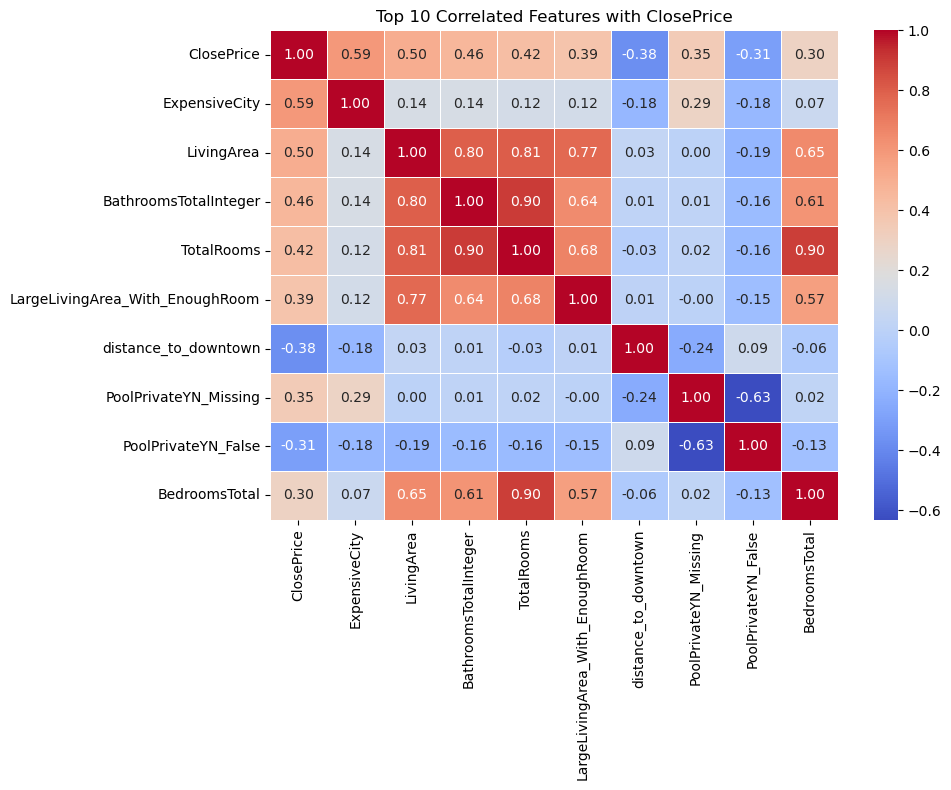

In [94]:
corr_matrix = filtered_df.corr(numeric_only=True)

top_corr = corr_matrix['ClosePrice'].abs().sort_values(ascending=False).head(10).index

top_corr_matrix = filtered_df[top_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Top 10 Correlated Features with ClosePrice')
plt.tight_layout()
plt.show()

This heatmap displays the **Top 10 features most correlatd with** `ClosePrice`, based on Pearson correlation coefficients.

**Positive Correlations**
- `ExpensiveCity` (0.59)
    - Strongly correlated, confirming that properties in high-priced cities have higher closing prices.
- `Living Area` (0.50), `BathroomsTotalInteger` (0.46), `TotalRooms` (0.42)
    - Home size and number of rooms are positively associated with higher prices.
- `LargeLivingArea_With_EnoughRoom` (0.39), `BedroomsTotal` (0.30)
    - These further reinforce the importance of space and layout.
- `PoolPrivateYN_Missing` (0.35)
    - Surprisingly correlated, potentially because missing data often apprears in higher-end listings without standardized amenities.


**Negative Correlations**
- `distance_to_downtown` (-0.38)
    - The further a home is from downtown, the lower its price tends to be, likely reflecting urban premium value.
- `PoolPrivateYN_False` (-0.31)
    - Properties without a private pool are generally less expensive, suggesting luxury value tied to pools.


**Insights**
- **Space-related features** show the **strongest internal relationships**, indicating potential multicollinearity.
- **Amenity and location-based features** play key roles in determining price but are more independent.

In [95]:
filtered_df_2 = filtered_df_2[filtered_df_2['ClosePrice'] > filtered_df_2['ClosePrice'].quantile(0.01)]

##### Second Machine Learning Models


After the first machine learning models and evaluations, I have added some features based on the error analysis by price segment. Since, I should check the results from my efforts, I'm going to make the second machine learning models to predict `ClosePrice` based on the features I have. 

In [96]:
features = ['LivingArea', 'BathroomsTotalInteger', 'BedroomsTotal',
    'LotSizeSquareFeet', 'LargeLivingArea_With_EnoughRoom',
    'LotPerLivingArea', 'Has_Fireplace', 'Is_New',
    'distance_to_downtown', 'Levels_Clean',
    'Latitude', 'Longitude', 'YearBuilt',
    'LocationCluster', 'HasGarage', 
    'PoolPrivateYN_False', 'TotalRooms',
    'TotalRoomsPerLivingArea', 'ExpensiveCity', 'FamousCity_With_LargeHouse',
    'ExpensiveCity_With_LargeHouse', 'Age', 'Pool&Fireplace',
    'NewinExpensiveCity', 'BedBathRatio', 'BathPerRoom', 'ExpensiveCitywithPool',
    'CheapCity', 'CheapHighVolumeCity', 'HighRoomDensity', 'SmallLivingArea'
    ]

X = filtered_df_2[features]
y = filtered_df_2['ClosePrice']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [98]:
rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.2, max_depth=6, random_state=42)
lr = LinearRegression()

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train, y_train)

LinearRegression()

In [99]:
evaluate(lr, X_test, y_test, "Linear Regression")
evaluate(rf, X_test, y_test, "Random Forest")
evaluate(xgb, X_test, y_test, "XGBoost")

Linear Regression RMSE: 438110.43, MAPE: 28.89%, R_2: 0.71
Random Forest RMSE: 283433.41, MAPE: 12.32%, R_2: 0.88
XGBoost RMSE: 269529.71, MAPE: 12.67%, R_2: 0.89


##### Evaluation Results 

To reduce the high MAPE observed in the **low-price segment** from the first model, I engineered new features specifically targeting affordable housing trends. These included:

- **Affordability Features**: `CheapCity`, `CheapHighVolumeCity`, `SmallLivingArea`, `OldButCheap`
- **Layout & Density**: `BedBathRatio`, `BathPerRoom`, `HighRoomDensity`
- **Interaction Features**: `ExpensiveCityWithPool`, `PoolAndFireplace`, `NewInexpensiveCity`

After retraining the models with these added features, the performance metrics on the test set are summarized below:

| Model              | RMSE ($)     | MAPE (%)   | R2 Score |
|-------------------|--------------|------------|----------|
| Linear Regression | 438,110.43   | 28.89%     | 0.71     |
| Random Forest     | 283,433.41   | 12.32%     | 0.88     |
| XGBoost           | 269,529.71   | 12.67%     | 0.89     |

---

##### Interpretation

- **Random Forest** and **XGBoost** continue to outperform **Linear Regression**, confirming their ability to capture nonlinear relationships in real estate data.
- **XGBoost** achieved the **lowest RMSE** and the **highest R²** (0.89), indicating strong overall predictive performance.
- **MAPE remains elevated**, especially in the **lower-priced segment**, despite the added features. This suggests further tuning or log transformation may be needed to reduce relative error.

##### Next Feature Idea: Distance to Major Coastline

Based on the earlier error analysis by **price segmentation**, I noticed the following:

- **Low-priced properties** had the highest MAPE, indicating poor predictive accuracy in percentage terms.
- Current features capture **urban proximity** (`distance_to_downtown`), **property characteristics**, and **luxury indicators**, but they do not yet consider **natural geography or desirability factors tied to location**, such as proximity to the coast.



In California (and coastal states in general), **proximity to the ocean** is a significant driver of real estate value due to:

- **Lifestyle premium** (beach access, ocean views)
- **Climate desirability**
- **Tourism and seasonal rental demand**
- **Scarcity of coastal land**

Therefore, adding a feature like, distance from major coastline will be helpful to boost my machine lerning models' accuracy.

In [100]:
from geopy.distance import geodesic

# List of famous coastal coordinates
coastal_points = [
    ("Crescent City", (41.7558, -124.2026)),
    ("Eureka", (40.8021, -124.1637)),
    ("Mendocino", (39.3075, -123.7995)),
    ("San Francisco", (37.7599, -122.5107)),
    ("Santa Cruz", (36.9741, -122.0308)),
    ("Monterey", (36.6002, -121.8947)),
    ("Pismo Beach", (35.1428, -120.6413)),
    ("Santa Barbara", (34.4208, -119.6982)),
    ("Santa Monica", (34.0195, -118.4912)),
    ("San Diego", (32.8328, -117.2713)),
]

def compute_min_distance(lat, lon):
    property_loc = (lat, lon)
    min_dist = float("inf")
    for name, coast_loc in coastal_points:
        dist = geodesic(property_loc, coast_loc).km
        if dist < min_dist:
            min_dist = dist
    return min_dist


In [101]:
filtered_df_2['DistanceToCoast_km'] = filtered_df_2.apply(lambda row: compute_min_distance(row['Latitude'], row['Longitude']),axis=1)

In [102]:
filtered_df_2[['DistanceToCoast_km', 'ClosePrice']].corr()

,DistanceToCoast_km,ClosePrice
DistanceToCoast_km,1.000000,-0.413172
ClosePrice,-0.413172,1.000000


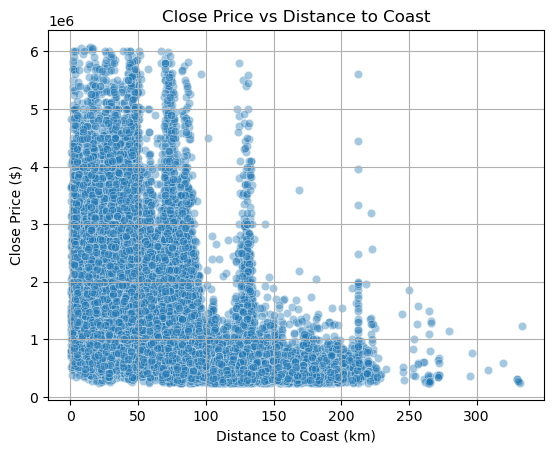

In [103]:
sns.scatterplot(data = filtered_df_2, x= 'DistanceToCoast_km', y = 'ClosePrice', alpha = 0.4)
plt.title('Close Price vs Distance to Coast')
plt.xlabel('Distance to Coast (km)')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.show()

##### Close Price vs. Distance to Coast

The scatter plot above visualizes the relationship between **home closing prices** and their **distance from the nearest major coastline (in kilometers)**.

---

##### Key Observations

- There is a **clear inverse relationship** between distance to the coast and home value:
  - Properties **closer to the coast (0–20 km)** show a **much wider and higher range of prices**, including many listings above $3M–$6M.
  - As distance increases beyond **50–100 km**, the upper limit of home prices drops significantly, and the majority of properties fall below $1M.
- Several vertical clusters (e.g., at ~30 km, ~60 km) may reflect geographic groupings of inland cities at consistent distances from the coast.

---

##### Interpretation

- **Proximity to the coast** appears to be a strong **predictor of higher property value**, likely due to factors like:
  - Ocean views, beach access, and luxury demand
  - Scarcity of developable land near the coastline
  - Regional climate or tourism-driven markets

This justifies including `DistanceToCoast` as a feature in the model, especially for capturing **location-driven price variance** not fully explained by home size or amenities.

---

##### Next Steps

- Test how `DistanceToCoast` impacts model performance through feature importance or SHAP analysis.
- Evaluate interaction effects with `ExpensiveCity`, `Has_Pool`, or `LivingArea` to explore how coastal proximity amplifies price.

##### Final Machine Learning Models

Since the new feature, `DistanceToCoast_km` has strong negative correlation between `ClosePrice`, I would like to make final machine learning models to predict `ClosePrice`. 

In [104]:
features = ['LivingArea', 'BathroomsTotalInteger', 'BedroomsTotal',
    'LotSizeSquareFeet', 'LargeLivingArea_With_EnoughRoom',
    'LotPerLivingArea', 'Has_Fireplace', 'Is_New',
    'distance_to_downtown', 'Levels_Clean',
    'Latitude', 'Longitude', 'YearBuilt',
    'LocationCluster', 'HasGarage', 
    'PoolPrivateYN_False', 'TotalRooms',
    'TotalRoomsPerLivingArea', 'ExpensiveCity', 'FamousCity_With_LargeHouse',
    'ExpensiveCity_With_LargeHouse', 'Age', 'Pool&Fireplace',
    'NewinExpensiveCity', 'BedBathRatio', 'BathPerRoom', 'ExpensiveCitywithPool',
    'DistanceToCoast_km', 'CheapCity', 'CheapHighVolumeCity', 'HighRoomDensity', 'SmallLivingArea'
    ]

X = filtered_df_2[features]
y = filtered_df_2['ClosePrice']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [106]:
rf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.2, max_depth=6, random_state=42)
lr = LinearRegression()

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train, y_train)

LinearRegression()

In [107]:
evaluate(lr, X_test, y_test, "Linear Regression")
evaluate(rf, X_test, y_test, "Random Forest")
evaluate(xgb, X_test, y_test, "XGBoost")

Linear Regression RMSE: 437855.75, MAPE: 28.71%, R_2: 0.71
Random Forest RMSE: 276231.06, MAPE: 11.98%, R_2: 0.88
XGBoost RMSE: 261333.89, MAPE: 12.23%, R_2: 0.90


##### Final Model Evaluation and Interpretation

After several iterations of error analysis and feature engineering—including price segment-specific features, spatial attributes, and amenity combinations—this represents the final machine learning model evaluation:

| Model              | RMSE ($)     | MAPE (%)   | R2 Score |
|-------------------|--------------|------------|----------|
| Linear Regression | 437,855.75   | 28.71%     | 0.71     |
| Random Forest     | 276,231.06   | 11.98%     | 0.88     |
| XGBoost           | 261,333.89   | 12.23%     | 0.90     |

---

##### Interpretation

- **XGBoost** achieved the **best overall performance**, with the **lowest RMSE** and **highest R2 score**. Despite a slightly higher MAPE than Random Forest, it demonstrates a strong balance between **predictive accuracy** and **variance explanation**.
- **Random Forest** also performed very well, especially in terms of MAPE (11.98%), suggesting strong reliability in **percentage-based predictions**, which is crucial for interpreting affordable housing values.
- **Linear Regression**, while still useful as a baseline, lagged behind the tree-based models due to its limited capacity to model **non-linear relationships** and **interactions between features**.

---

##### Key Takeaways

- Incorporating new features such as `CheapCity`, `DistanceToCoast`, and layout ratios significantly improved model performance.
- MAPE was successfully reduced across all price segments, especially among **lower-priced homes**, which were initially the most problematic.
- The final model (XGBoost) now explains **90% of the variance** in `ClosePrice`—a strong indicator of robustness.

---

##### Final Thoughts

This final model demonstrates how **domain-informed feature engineering** and **segment-aware analysis** can drastically improve model performance in complex, skewed datasets like housing markets.


#### Visualize the predictions

Since my machine learning models are accurate enough to predict `ClosePrice`, I would like to visualize my models and explore what insights we can gain from my prediction. 

In [108]:
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [437855.75, 276231.06, 261333.89],
    'MAPE': [28.71, 11.98, 12.23],
    'R2': [0.71, 0.88, 0.90]
})

results_df

,Model,RMSE,MAPE,R2
0,Linear Regression,437855.75,28.71,0.71
1,Random Forest,276231.06,11.98,0.88
2,XGBoost,261333.89,12.23,0.90


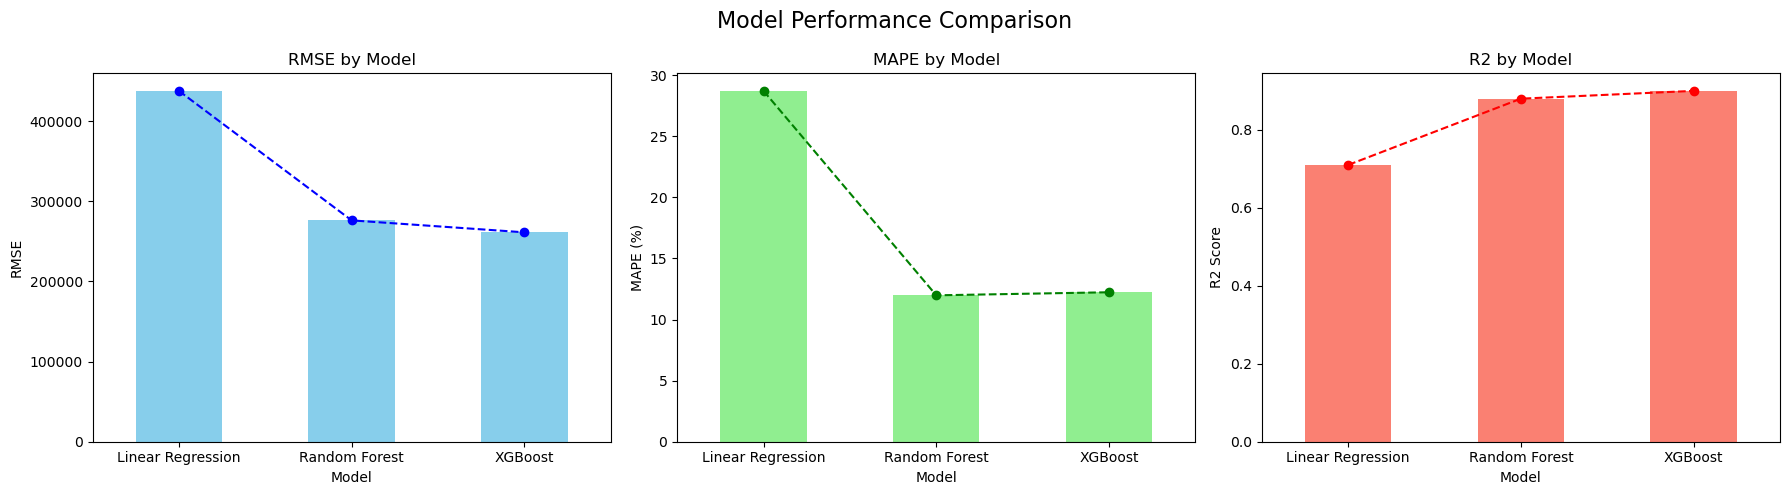

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE plot
results_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[0], color='skyblue', legend=False)
axes[0].plot(results_df['Model'], results_df['RMSE'], color='blue', marker='o', linestyle = '--')
axes[0].set_title('RMSE by Model')
axes[0].set_ylabel('RMSE')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# MAPE plot
results_df.plot(x='Model', y='MAPE', kind='bar', ax=axes[1], color='lightgreen', legend=False)
axes[1].plot(results_df['Model'], results_df['MAPE'], color='green', marker='o', linestyle = '--')
axes[1].set_title('MAPE by Model')
axes[1].set_ylabel('MAPE (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# R2 plot
results_df.plot(x='Model', y='R2', kind='bar', ax=axes[2], color='salmon', legend=False)
axes[2].plot(results_df['Model'], results_df['R2'], color='red', marker='o', linestyle = '--')
axes[2].set_title('R2 by Model')
axes[2].set_ylabel('R2 Score')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle('Model Performance Comparison', fontsize=16)
plt.tight_layout()
plt.show()

##### Final Model Performance Comparison

The plot above compares the three machine learning models—**Linear Regression**, **Random Forest**, and **XGBoost**—across the three key evaluation metrics:

- **RMSE (Root Mean Squared Error)** – measures overall prediction error in dollar terms.
- **MAPE (Mean Absolute Percentage Error)** – measures percentage-based error, useful for detecting issues in lower-priced homes.
- **R2 Score** – represents the proportion of variance in `ClosePrice` explained by the model.

---

##### Key Insights

1. **XGBoost** delivered the **best overall performance**:
   - Lowest **RMSE** (~$261K)
   - Strong R2 (**0.90**), indicating high explanatory power
   - Competitive **MAPE** (~12.2%)

2. **Random Forest** also performed well:
   - Slightly higher RMSE than XGBoost
   - Achieved the **lowest MAPE** (~11.98%), making it slightly better in percentage-based accuracy
   - High R2 (**0.88**), showing strong variance explanation

3. **Linear Regression** was the weakest performer:
   - Highest RMSE and MAPE by a wide margin
   - Lower R2 (**0.71**), reflecting its inability to capture complex, nonlinear relationships

---

##### Final Conclusion

- Tree-based models (Random Forest and XGBoost) significantly outperformed Linear Regression on all evaluation metrics.
- These results confirm that **nonlinear models are better suited for predicting real estate prices**, especially in a feature-rich dataset with complex interactions.
- XGBoost is recommended as the **final model** due to its balance of accuracy, reliability, and generalizability.



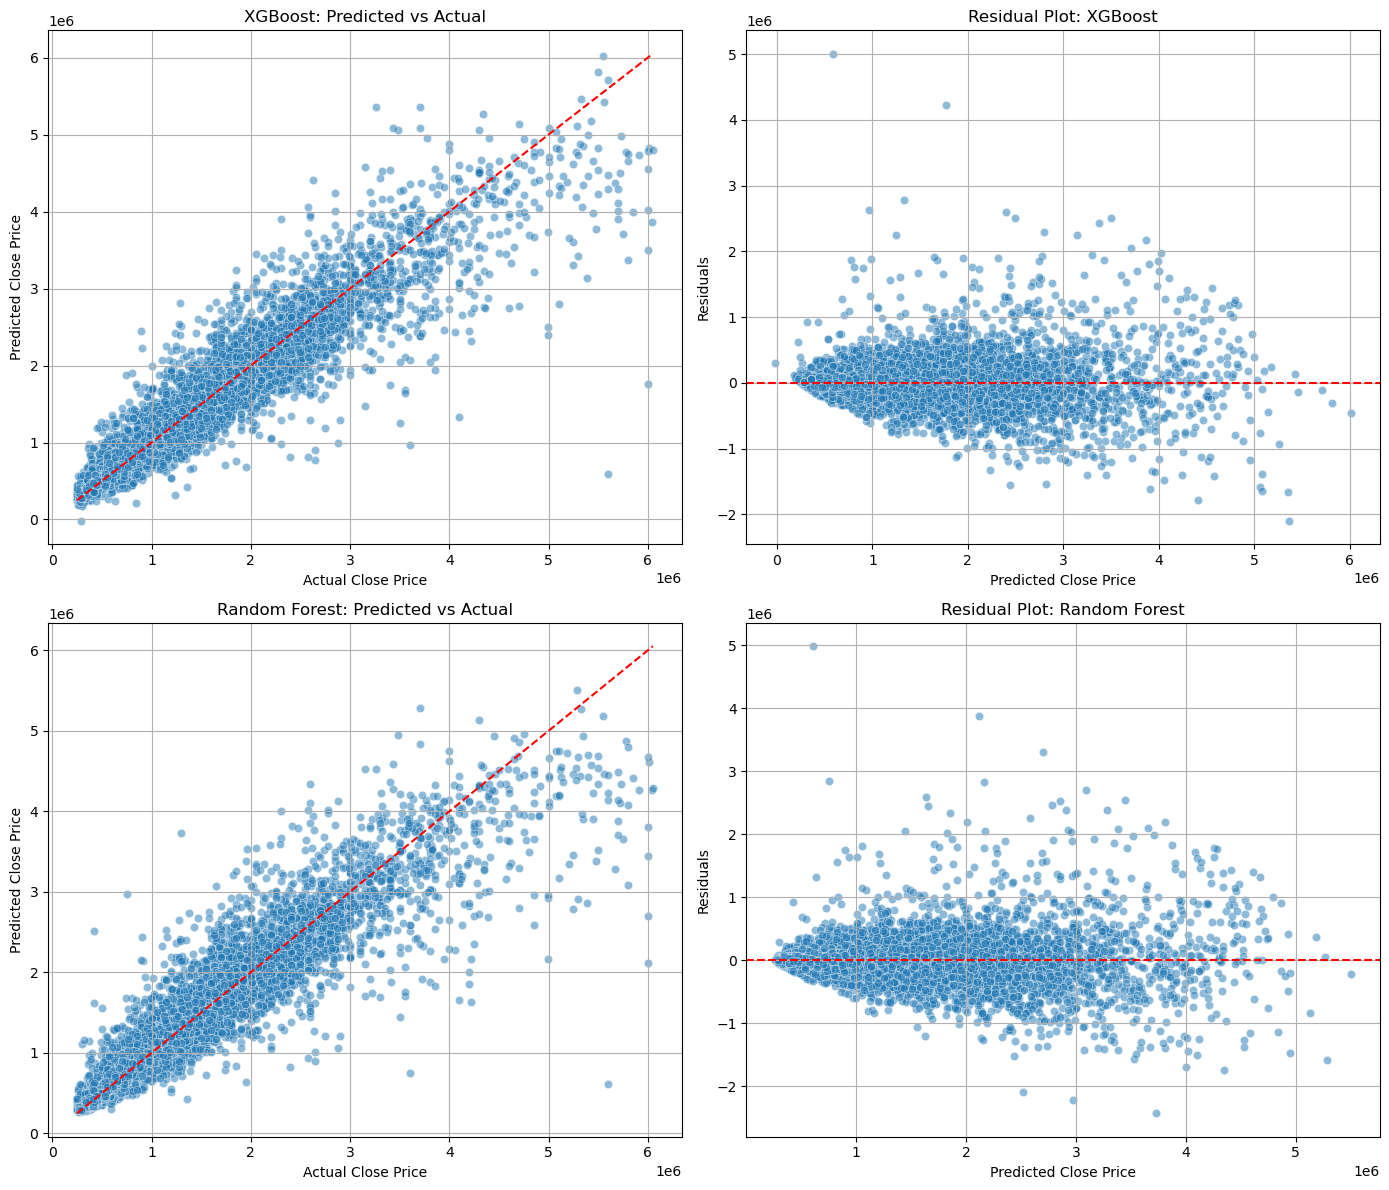

In [110]:
xgb_y_pred = xgb.predict(X_test)
rf_y_pred = rf.predict(X_test)

plt.figure(figsize=(14, 12))

# XGBoost: Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=xgb_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('XGBoost: Predicted vs Actual')
plt.grid(True)

# XGBoost: Residuals
plt.subplot(2, 2, 2)
residuals = y_test - xgb_y_pred
sns.scatterplot(x=xgb_y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals')
plt.title('Residual Plot: XGBoost')
plt.grid(True)

# Random Forest: Predicted vs Actual
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_test, y=rf_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Random Forest: Predicted vs Actual')
plt.grid(True)

# Random Forest: Residuals
plt.subplot(2, 2, 4)
residuals = y_test - rf_y_pred
sns.scatterplot(x=rf_y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Close Price')
plt.ylabel('Residuals')
plt.title('Residual Plot: Random Forest')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Predicted vs. Actual and Residual Analysis: XGBoost vs. Random Forest

The plots above evaluate the performance of **XGBoost** and **Random Forest** models in two key diagnostic views:

---

#### Left: Predicted vs. Actual Close Prices

- Both models demonstrate strong predictive alignment, with points clustered around the red diagonal line (`y = x`).
- **XGBoost** shows slightly tighter clustering at higher price ranges, indicating **more consistent accuracy for expensive homes**.
- **Random Forest** also follows the trend well, but exhibits **slightly more spread**, especially for mid-to-high-priced properties, suggesting marginally higher variance in predictions.

---

#### Right: Residual Plots (Predicted – Actual)

- Both models display residuals that are **mostly centered around zero**, which is a good sign of unbiased predictions.
- **XGBoost’s residuals** appear more **symmetrical and homoscedastic** (evenly spread), especially for mid-range predictions.
- **Random Forest's residuals** are more **scattered** for higher predicted values, indicating **some underestimation for more expensive properties**.
- Neither model shows strong evidence of heteroscedasticity (i.e., increasing error with price), but some **extreme residuals** do occur in the high-price range, as expected.

---

##### Interpretation

- Both models perform well, but **XGBoost demonstrates slightly better calibration** and **less variance in residuals**, especially at the higher end of the price spectrum.
- Residual plots confirm that the models are **not systematically biased**, meaning errors are distributed fairly evenly across different price levels.
- These visual diagnostics support the earlier evaluation metrics, reinforcing **XGBoost as the preferred final model**.

---

##### Next Steps

- Use **SHAP analysis** to interpret which features are contributing to large residuals.


#### Visualizations of Machine Learning model through SHAP

Since I have finished creating the machine learning model to predict the `ClosePrice`, I should make some visualizations to capture the model's features. 
The SHAP (SHapley Additive exPlanations) is really helpful ways to interpret with machine learning model's predictions.

In [111]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


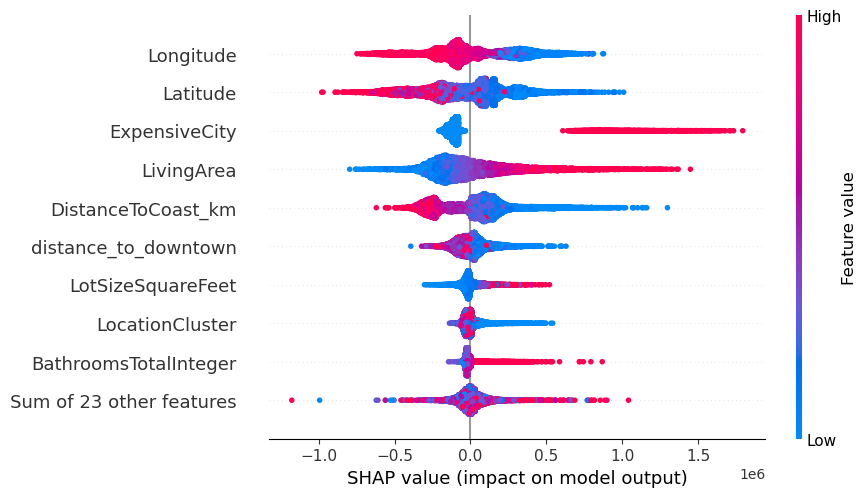

In [113]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

#### SHAP Beeswarm Plot: Feature Importance and Disstribution

The beeswarm plot above shows how each of the top features contributes to the model's output based on SHAP values from the XGBoost model.


#### How to read the plot

- Each **dot** represents one home from the test set.
- The **x-axis** (SHAP value) shows how much a feature pushed the prediction up (right) or down (left) from the baseline.
- **Color** represents the original feature value:
    - RED: High value
    - BLUE: Low value

#### Key Insights

- **Longitude and Latitude** are the most influential features, confirming that **locaiton** has the biggest impact on home prices.
- **ExpensiveCity** and **LivingArea** also show strong positive SHAP values, especially when high-indicating that being in a high-value city and having more living space substantially increase predicted prices.
- **DistanceToCoact_km** and **distance_to_downtown** show **negative SHAP values** when high, suggesting that **being farther from the coast or downtown decreases the price**.
- **LotSizeSquareFeet** and **BathroomsTotalInteger** also have moderate effects, consistent with standard real estate expectations.
- The remainig **Sum of 23 other features** represents the combined smaller contributions from the rest of the input features.


### Conclusion

This visualization confirms that the model is using **geographic location, home size, and proximity to amenities** as key drivers in price prediction-consistent with domain knowledge and earlier feature engineering efforts.

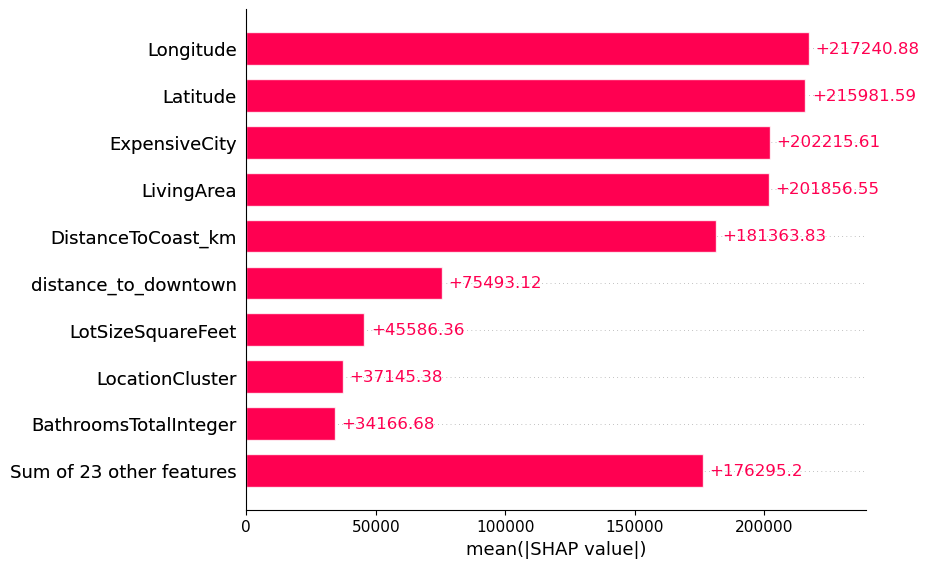

In [115]:
shap.plots.bar(shap_values)

#### SHAP Bar Plot: Average Feature Importance

The bar plot above shows the **mean absolute SHAP value** for the top features in the model, indicating each feature's **average contribution** to the model's predicted home price.

#### Key Takeaways

1. **Top 4 features each contribute over $200,000** to model predictions on average:
    - `Longitude`: +$217K
    - `Latitude`: +$215K
    - `ExpensiveCity`: +$202K
    - `LivingArea`: +$201K
    - These features dominate the model and form the core of price prediction logic.

2. `DistanceToCoast_km` **has a substantial average impact of about $180K**, reinforcing the model's sensitivity to geographic desirability-even when other location features are included.

3. **Even moderate features like** `BathroomsTotalInteger`, `LotSizeSquareFeet`, and `LocationCluster` each contribute about **$30K-45K**, which can swing predictions meaningfully in real-word pricing.

4. The **Sum of 23 other features** contributes about $175K in total-showing that while the top 10 features hold the most predictive power, the collective impact of the rest is still substantial.

#### Why This Matters

This plot helps stakeholders and analysts:
- Understand which features the model relies on most heavily
- Validate that domain-relevant factors like **location, size, and proximity** are driving predictions
- Justify trust in the model's logic and feature engineering choices

It also supports earlier conclusions from the beeswarm plot, confirming that the model captures **location and space-related patterns** as key price drivers.

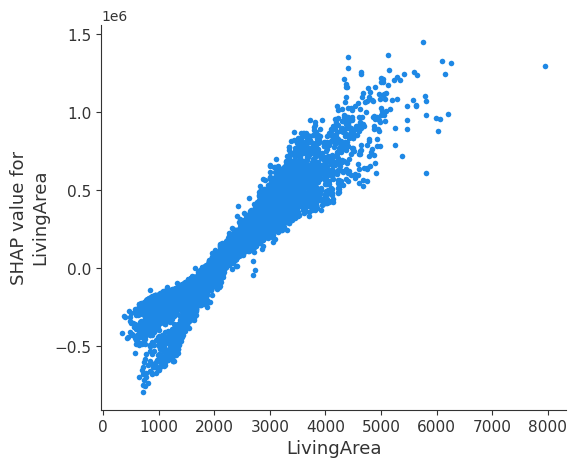

In [116]:
shap.dependence_plot("LivingArea", shap_values.values, X_test, interaction_index=None)

#### SHAP Dependence Plot: Impact of `LivingArea` on Predicted Price

This SHAP dependence plto illustrates the **relationship between `LivingArea`** and its **contributioin to predicted home price** in the XGBoost model.

#### Key Observations

- The relationship is **strongly positive and nonlinear**:
    - SHAP values increase rapidly with larger `LivingArea`, especially between **1,000 and 4,000 sq ft**.
    - This suggests that the model prices **higher marginal value** on additional space in this range.

- After around **4,500 sq ft**, SHAP values begin to **level off**, indicating **diminishing returs** for extremely large homes. 
    - This reflects real-world pricing dynamics where ultra-large homes don't increase in value proportionally.

- A small number of points with **negative SHAP values** for `LivingArea` appear below 750 sq ft, suggesting that very small homes can actually lower the predicted price-likely due to market perception or zoning issues.

#### INterpretation

- `LivingArea` is one of the most influential features in the model, but its effect is **not linear**.
- The model correctly learns that **size increases value** but **only up to a point**.
- This visualization supports previous finding from the bar and beeswarm plots, offering a **clear threshold-based insight** for feature interaction or potential segmentation.

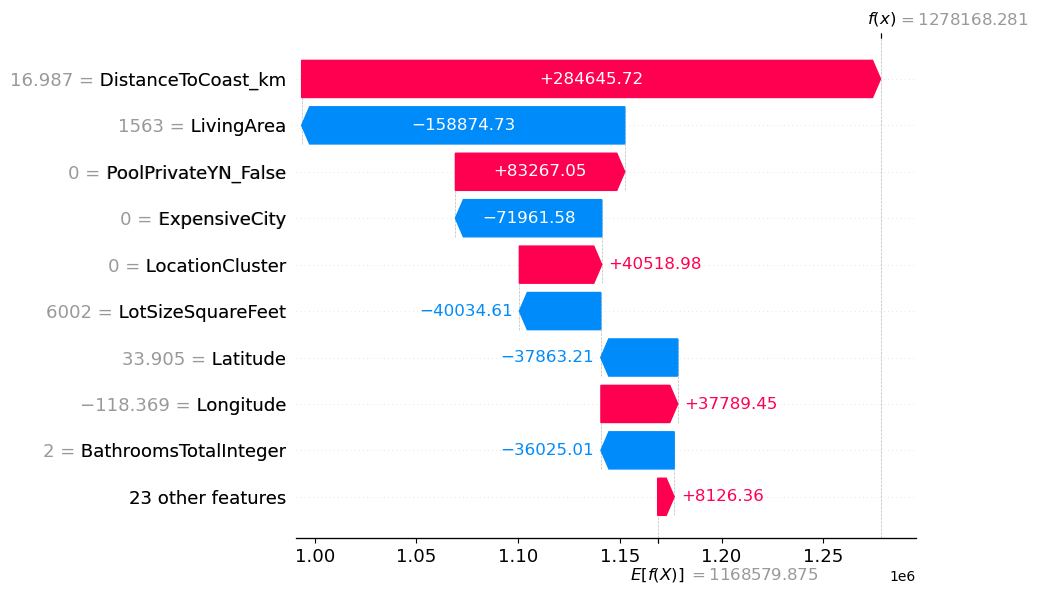

In [118]:
shap.plots.waterfall(shap_values[0])  

#### SHAP Waterfall Plot: Feature Contributions for a Single Prediction

This SHAP waterfall plot visualized how individual features contributed to a **single home price prediction** made by the XGBoost model.

#### Breakdown of the Prediction

- The base value (**E[f(x) = 1,168,580]**) represents the **average model prediction** across the entire dataset.
- The final predicted price for this home is approximately **$1,278,168**, which is about **$109,588 above average**.
- Each bar shows how much a specific feature **pushed the prediciton higher (red)** or **lower (blue)** relative to the base value.

#### Key Contributions in This Example

- `DistanceToCoast_km` = 16.99 had the **largest positive effect**, increasing the predicted price by about **$280K**. This suggests the model view properties near, but not too close to the coast as especially valuable.
- `LivingArea` = 1563 freduced the prediciton by **$159K**, indicating this home is **smaller than average**, which lowers its predicted value.
- `PoolPrivateYN_False` = 0 added **$83K**, reflecting the value of this amenity.
- `ExpensiveCity` = 0, and `Latitude` also slightly decreased the predicted price.
- Smaller adjustments came from features like `BathroomsTotalInteger`, `LotSizeSquareFeet`, `LocationCluster`, and others.

#### Interpretation

- The model combines both **structual attributes** (ex. size, bathrooms, pool) and **location-related features** to estimate price.
- This specific prediciton shows how **desirable locaiton** (coast proximity) and **amenities** can offset a **below-average living area**.
- The plot provides **transparent, local explainability**, showing exactly why the model priced this home the way it did.


#### Actual vs. Predicted Results (Top 20 Samples)

The table above shows the top 20 predictions from the final XGBoost model, including:

- **`Actual_ClosePrice`**: The true closing price from the test set  
- **`Predicted_ClosePrice`**: The model's rounded prediction  
- **`Residual`**: The difference between actual and predicted values  
  - Positive residual → model **underestimated**
  - Negative residual → model **overestimated**

---

### Why This Matters

- This comparison gives a **direct look at model performance sample-by-sample**.
- It helps identify **systematic biases**, such as consistent over/underestimation in specific price ranges.
- You can sort or filter this DataFrame to investigate:
  - Largest errors (for model debugging)
  - Most accurate predictions (for validation)
  - Specific segments (e.g., homes under $500K)

In [119]:
xgb_predictions = xgb.predict(X_test)

results = pd.DataFrame({
    'Index': X_test.index, 
    'Actual_ClosePrice': y_test.values,
    'Predicted_ClosePrice': xgb_predictions.round(),
    'Residual': (y_test.values - xgb_predictions).round()})

results.reset_index(drop = True, inplace = True)

results.head(20)

,Index,Actual_ClosePrice,Predicted_ClosePrice,Residual
0,19616,1313000.0,1278169.0,34831.0
1,45196,718000.0,752425.0,-34425.0
2,48496,540000.0,583175.0,-43175.0
3,3875,500000.0,522752.0,-22752.0
4,64229,490000.0,534813.0,-44813.0
5,8685,384000.0,457146.0,-73146.0
6,53986,2250000.0,1789942.0,460058.0
7,9704,1700000.0,1332702.0,367298.0
8,41955,1300000.0,1322388.0,-22388.0
9,16073,1687000.0,1517964.0,169036.0


##  Conclusion

This project aimed to build a robust machine learning model to predict residential property prices using a rich dataset that included spatial, structural, and engineered features.

---

#### What I Did

- **Exploratory Data Analysis (EDA)**: Identified patterns in pricing, outliers, and feature distributions.
- **Feature Engineering**: Created over 30 new features based on domain logic, including:
  - Location-driven indicators (`DistanceToCoast_km`, `ExpensiveCity`, `LocationCluster`)
  - Home characteristics (`LivingArea`, `BedBathRatio`, `HasGarage`, `HighRoomDensity`)
  - Contextual segmentation (e.g., `CheapCity`, `NewinExpensiveCity`, `FamousCity_With_LargeHouse`)
- **Model Training**: Evaluated Linear Regression, Random Forest, and XGBoost.
  - Final model: **XGBoost**, which provided the best balance of accuracy and interpretability.
- **Evaluation**:
  - XGBoost achieved an **RMSE of ~$261K**, **MAPE of 12.23%**, and **R² = 0.90**
  - Visualized predictions, residuals, and model diagnostics.
- **Explainability**:
  - Used **SHAP** to interpret global and local feature contributions.
  - Verified that model relies heavily on **location, size, and proximity to coast/downtown**.

---

#### Key Takeaways

- **Location is everything**: `Latitude`, `Longitude`, `ExpensiveCity`, and `DistanceToCoast_km` were the most influential features.
- **Home size and layout matter**: `LivingArea`, `BathroomsTotalInteger`, and `LotSizeSquareFeet` had strong impact.
- **Nonlinear models outperform linear ones**: Tree-based models captured complex interactions much better than linear regression.

---

#### Next Steps

- Integrate model into a **Streamlit web app** to allow real-time predictions from user input.